# ML Pipeline Overview: Predicting Canopy-Change Classes

This project develops a machine learning pipeline to classify vegetation blocks across NEON field sites as **Gain**, **Stable**, or **Loss**, using structural canopy data (CHM), spectral indices (NDVI, EVI, etc.), and terrain variables (slope, aspect). Emphasis was placed on data alignment, block-level analysis, feature integrity, and ecologically meaningful classification.

---

**Phase 1: Data Preparation**

- **Mosaicking VI Tiles:** Combined 1 m vegetation index tiles into 1 km² mosaics for each site-year-index.
- **Spatial Alignment:** Selected the earliest-year CHM mosaic as the spatial reference per site. Reprojected and resampled all CHM, VI, and terrain rasters to match that grid.

---

**Phase 2: Feature Extraction**

- **Block Sampling:** Divided rasters into 100×100 pixel blocks for analysis.
- **CHM Statistics:** Computed percent gain/loss/stable based on ±1.5 m thresholds, plus CHM block stats (mean, std, p95, IQR, etc.).
- **Vegetation Indices:** Calculated mean NDVI, EVI, ARVI, PRI, and SAVI per block.

---

**Phase 3: Class Distribution**

- **Labeling:** Assigned block labels using a 10% change threshold for gain/loss.
- **Justification:** 10% provided the best compromise between class balance and ecological validity.
- **Distribution Analysis:** Revealed heavy skew toward “Stable” blocks; this informed decisions around balancing.

---

**Phase 4: Expanding the Feature Set: Incorporating Topographic Context**

- **Feature Evaluation:** Assessed the contribution of slope and aspect to classification.
- **Terrain-Only Modeling:** A baseline Random Forest trained using only slope and aspect showed strong performance for Gain and Stable, but struggled on Loss.

---

**Phase 5: Hybrid Resampling and Model Training**

- **Integrated Model:** Trained a full Random Forest using all features (CHM, VI, terrain).
- **Performance:** Achieved ~96% accuracy. Gain and Stable were well-classified; Loss remained a challenge.
- **Feature Importance:** Structural features were most predictive; VIs added value; terrain features provided moderate support.

---

**Phase 6: Model Reassessment and Feature Integrity Check**

- **Alignment Checks:** Verified CHM and terrain raster alignment via shape, transform, and CRS.
- **Residual Analysis:** Examined misclassifications using a confusion matrix and prediction errors, especially for Loss cases.
- **Improvement Areas:** Identified spatial or ecological drivers of errors; suggested better thresholds or alternative resampling strategies.

---

**Phase 7: Spatial Prediction and Visualization**

- **Export:** Saved block predictions (with coordinates) to CSV.
- **Mapping:** Visualized prediction maps per site-year. Plots of predicted vs. actual canopy change showed strong spatial agreement, especially at NIWO.
- **Insight:** Validated that model outputs aligned well with known CHM differences.

---

This pipeline illustrates a scalable, interpretable method for mapping canopy change using fused structural, spectral, and terrain data. It supports ecological analysis and can be extended to additional NEON sites or future time periods.


## Phase 1: Data Preparation

### Step 1: Create 1 km × 1 km Vegetation-Index Mosaics

We take the raw 1 m VegIndex tiles (NDVI, EVI, ARVI, PRI, SAVI) and, for each NEON site and year:

1. **Discover tiles** in `veg_indices/{site}/{year}` for each index.  
2. **Merge** all 1 m tiles into a single 1 km × 1 km mosaic using `rasterio.merge`.  
3. **Write out** one GeoTIFF per index (`{site}_{year}_{index}_mos.tif`) into `veg_mosaics/{site}/{year}`.  

This produces aligned, convenient mosaic files for every index, ready for alignment to our CHM grid in Phase 2.  

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from tqdm import tqdm
import os, glob
import numpy as np
import rasterio
from rasterio.merge import merge

In [29]:
from tqdm import tqdm

# build mosaics for each site/year/index with progress bars 
import os, glob
import numpy as np
import rasterio
from rasterio.merge import merge

veg_root    = r"D:/MSDS/MSDS 696_Practicum II/veg_indices"
mosaic_root = veg_root.replace("veg_indices", "veg_mosaics")
os.makedirs(mosaic_root, exist_ok=True)

INDICES    = ["NDVI","EVI","ARVI","PRI","SAVI"]
site_codes = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]

def get_year(fname):
    import re
    m = re.search(r"(\d{4})", fname)
    return m.group(1) if m else None

# wrap the outermost loop in tqdm
for site in tqdm(site_codes, desc="Sites"):
    years = sorted(os.listdir(os.path.join(veg_root, site)))
    for year in tqdm(years, desc=f"{site} Years", leave=False):
        in_dir = os.path.join(veg_root, site, year)
        if not os.path.isdir(in_dir): 
            continue

        out_dir = os.path.join(mosaic_root, site, year)
        os.makedirs(out_dir, exist_ok=True)

        # wrap the index loop in tqdm as well
        for idx in tqdm(INDICES, desc=f"{site} {year} Indices", leave=False):
            tiles = glob.glob(os.path.join(in_dir, f"*_{idx}.tif"))
            if not tiles:
                continue

            # read + merge
            srcs = [rasterio.open(t) for t in tiles]
            mosaic, trans = merge(srcs)
            meta = srcs[0].meta.copy()
            for s in srcs: s.close()

            # update metadata
            meta.update({
                "height":    mosaic.shape[1],
                "width":     mosaic.shape[2],
                "transform": trans
            })

            out_fp = os.path.join(out_dir, f"{site}_{year}_{idx}_mos.tif")
            with rasterio.open(out_fp, "w", **meta) as dst:
                dst.write(mosaic)

        # you can still keep the summary print if you like
        print(f"✅ {site} {year}: mosaicked {len(INDICES)} indices → {out_dir}")

NIWO Years:   0%|          | 0/5 [00:00<?, ?it/s]

NIWO 2017 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

NIWO 2017 Indices:  20%|██        | 1/5 [00:14<00:56, 14.19s/it]

NIWO 2017 Indices:  40%|████      | 2/5 [00:36<00:57, 19.03s/it]

NIWO 2017 Indices:  60%|██████    | 3/5 [00:59<00:41, 20.95s/it]

NIWO 2017 Indices:  80%|████████  | 4/5 [01:21<00:21, 21.41s/it]

NIWO 2017 Indices: 100%|██████████| 5/5 [01:43<00:00, 21.29s/it]

                                                                
NIWO Years:  20%|██        | 1/5 [01:43<06:52, 103.04s/it]

✅ NIWO 2017: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\NIWO\2017




NIWO 2018 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

NIWO 2018 Indices:  20%|██        | 1/5 [00:23<01:35, 23.97s/it]

NIWO 2018 Indices:  40%|████      | 2/5 [00:48<01:12, 24.11s/it]

NIWO 2018 Indices:  60%|██████    | 3/5 [01:11<00:47, 23.55s/it]

NIWO 2018 Indices:  80%|████████  | 4/5 [01:33<00:23, 23.09s/it]

NIWO 2018 Indices: 100%|██████████| 5/5 [01:55<00:00, 22.83s/it]

                                                                
NIWO Years:  40%|████      | 2/5 [03:38<05:31, 110.55s/it]

✅ NIWO 2018: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\NIWO\2018




NIWO 2019 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

NIWO 2019 Indices:  20%|██        | 1/5 [00:30<02:00, 30.12s/it]

NIWO 2019 Indices:  40%|████      | 2/5 [00:59<01:29, 29.67s/it]

NIWO 2019 Indices:  60%|██████    | 3/5 [01:30<01:00, 30.48s/it]

NIWO 2019 Indices:  80%|████████  | 4/5 [01:59<00:29, 29.66s/it]

NIWO 2019 Indices: 100%|██████████| 5/5 [02:27<00:00, 28.97s/it]

                                                                
NIWO Years:  60%|██████    | 3/5 [06:05<04:14, 127.24s/it]

✅ NIWO 2019: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\NIWO\2019




NIWO 2020 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

NIWO 2020 Indices:  20%|██        | 1/5 [00:22<01:30, 22.64s/it]

NIWO 2020 Indices:  40%|████      | 2/5 [00:44<01:06, 22.31s/it]

NIWO 2020 Indices:  60%|██████    | 3/5 [01:06<00:44, 22.23s/it]

NIWO 2020 Indices:  80%|████████  | 4/5 [01:30<00:22, 22.65s/it]

NIWO 2020 Indices: 100%|██████████| 5/5 [01:58<00:00, 24.56s/it]

                                                                
Sites:  17%|█▋        | 1/6 [08:04<40:20, 484.11s/it]     

✅ NIWO 2020: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\NIWO\2020



WLOU Years:   0%|          | 0/4 [00:00<?, ?it/s]

WLOU 2017 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

WLOU 2017 Indices:  20%|██        | 1/5 [00:05<00:23,  5.76s/it]

WLOU 2017 Indices:  40%|████      | 2/5 [00:10<00:15,  5.13s/it]

WLOU 2017 Indices:  60%|██████    | 3/5 [00:14<00:09,  4.54s/it]

WLOU 2017 Indices:  80%|████████  | 4/5 [00:18<00:04,  4.54s/it]

WLOU 2017 Indices: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]

                                                                
WLOU Years:  25%|██▌       | 1/4 [00:23<01:11, 23.92s/it]

✅ WLOU 2017: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\WLOU\2017




WLOU 2019 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

WLOU 2019 Indices:  20%|██        | 1/5 [00:05<00:20,  5.13s/it]

WLOU 2019 Indices:  40%|████      | 2/5 [00:11<00:17,  5.83s/it]

WLOU 2019 Indices:  60%|██████    | 3/5 [00:18<00:12,  6.40s/it]

WLOU 2019 Indices:  80%|████████  | 4/5 [00:23<00:06,  6.02s/it]

WLOU 2019 Indices: 100%|██████████| 5/5 [00:31<00:00,  6.40s/it]

                                                                
WLOU Years:  50%|█████     | 2/4 [00:54<00:56, 28.12s/it]

✅ WLOU 2019: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\WLOU\2019




WLOU 2020 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

WLOU 2020 Indices:  20%|██        | 1/5 [00:04<00:17,  4.47s/it]

WLOU 2020 Indices:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]

WLOU 2020 Indices:  60%|██████    | 3/5 [00:14<00:09,  4.74s/it]

WLOU 2020 Indices:  80%|████████  | 4/5 [00:20<00:05,  5.12s/it]

WLOU 2020 Indices: 100%|██████████| 5/5 [00:23<00:00,  4.66s/it]

                                                                
Sites:  33%|███▎      | 2/6 [09:23<16:23, 245.78s/it]    

✅ WLOU 2020: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\WLOU\2020



STER Years:   0%|          | 0/2 [00:00<?, ?it/s]

STER 2017 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

STER 2017 Indices:  20%|██        | 1/5 [00:14<00:58, 14.67s/it]

STER 2017 Indices:  40%|████      | 2/5 [00:32<00:49, 16.46s/it]

STER 2017 Indices:  60%|██████    | 3/5 [00:49<00:33, 16.83s/it]

STER 2017 Indices:  80%|████████  | 4/5 [01:07<00:17, 17.29s/it]

STER 2017 Indices: 100%|██████████| 5/5 [01:24<00:00, 17.06s/it]

                                                                
Sites:  50%|█████     | 3/6 [10:47<08:36, 172.05s/it]    

✅ STER 2017: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\STER\2017



RMNP Years:   0%|          | 0/4 [00:00<?, ?it/s]

RMNP 2017 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

RMNP 2017 Indices:  20%|██        | 1/5 [00:24<01:38, 24.74s/it]

RMNP 2017 Indices:  40%|████      | 2/5 [00:50<01:15, 25.08s/it]

RMNP 2017 Indices:  60%|██████    | 3/5 [01:14<00:49, 24.98s/it]

RMNP 2017 Indices:  80%|████████  | 4/5 [01:40<00:25, 25.04s/it]

RMNP 2017 Indices: 100%|██████████| 5/5 [02:05<00:00, 25.07s/it]

                                                                
RMNP Years:  25%|██▌       | 1/4 [02:05<06:15, 125.20s/it]

✅ RMNP 2017: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\RMNP\2017




RMNP 2018 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

RMNP 2018 Indices:  20%|██        | 1/5 [00:28<01:52, 28.18s/it]

RMNP 2018 Indices:  40%|████      | 2/5 [00:56<01:25, 28.54s/it]

RMNP 2018 Indices:  60%|██████    | 3/5 [01:25<00:56, 28.42s/it]

RMNP 2018 Indices:  80%|████████  | 4/5 [01:53<00:28, 28.43s/it]

RMNP 2018 Indices: 100%|██████████| 5/5 [02:22<00:00, 28.64s/it]

                                                                
RMNP Years:  50%|█████     | 2/4 [04:27<04:30, 135.50s/it]

✅ RMNP 2018: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\RMNP\2018




RMNP 2020 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

RMNP 2020 Indices:  20%|██        | 1/5 [00:27<01:49, 27.44s/it]

RMNP 2020 Indices:  40%|████      | 2/5 [00:55<01:23, 27.87s/it]

RMNP 2020 Indices:  60%|██████    | 3/5 [01:23<00:55, 27.91s/it]

RMNP 2020 Indices:  80%|████████  | 4/5 [01:51<00:28, 28.01s/it]

RMNP 2020 Indices: 100%|██████████| 5/5 [02:19<00:00, 27.75s/it]

                                                                
Sites:  67%|██████▋   | 4/6 [17:34<08:49, 264.78s/it]     

✅ RMNP 2020: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\RMNP\2020



CPER Years:   0%|          | 0/4 [00:00<?, ?it/s]

CPER 2013 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

CPER 2013 Indices:  20%|██        | 1/5 [00:14<00:59, 14.88s/it]

CPER 2013 Indices:  40%|████      | 2/5 [00:30<00:46, 15.52s/it]

CPER 2013 Indices:  60%|██████    | 3/5 [00:47<00:31, 15.86s/it]

CPER 2013 Indices:  80%|████████  | 4/5 [01:02<00:15, 15.84s/it]

CPER 2013 Indices: 100%|██████████| 5/5 [01:18<00:00, 15.78s/it]

                                                                
CPER Years:  25%|██▌       | 1/4 [01:18<03:55, 78.62s/it]

✅ CPER 2013: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\CPER\2013




CPER 2017 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

CPER 2017 Indices:  20%|██        | 1/5 [00:18<01:14, 18.53s/it]

CPER 2017 Indices:  40%|████      | 2/5 [00:37<00:56, 18.70s/it]

CPER 2017 Indices:  60%|██████    | 3/5 [00:57<00:39, 19.55s/it]

CPER 2017 Indices:  80%|████████  | 4/5 [01:14<00:18, 18.24s/it]

CPER 2017 Indices: 100%|██████████| 5/5 [01:29<00:00, 17.28s/it]

                                                                
CPER Years:  50%|█████     | 2/4 [02:48<02:50, 85.15s/it]

✅ CPER 2017: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\CPER\2017




CPER 2020 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

CPER 2020 Indices:  20%|██        | 1/5 [00:18<01:12, 18.00s/it]

CPER 2020 Indices:  40%|████      | 2/5 [00:38<00:58, 19.61s/it]

CPER 2020 Indices:  60%|██████    | 3/5 [00:59<00:40, 20.28s/it]

CPER 2020 Indices:  80%|████████  | 4/5 [01:17<00:19, 19.12s/it]

CPER 2020 Indices: 100%|██████████| 5/5 [01:34<00:00, 18.49s/it]

                                                                
Sites:  83%|████████▎ | 5/6 [21:57<04:24, 264.10s/it]    

✅ CPER 2020: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\CPER\2020



ARIK Years:   0%|          | 0/3 [00:00<?, ?it/s]

ARIK 2017 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

ARIK 2017 Indices:  20%|██        | 1/5 [00:27<01:48, 27.19s/it]

ARIK 2017 Indices:  40%|████      | 2/5 [00:53<01:20, 26.91s/it]

ARIK 2017 Indices:  60%|██████    | 3/5 [01:23<00:56, 28.04s/it]

ARIK 2017 Indices:  80%|████████  | 4/5 [01:52<00:28, 28.62s/it]

ARIK 2017 Indices: 100%|██████████| 5/5 [02:20<00:00, 28.27s/it]

                                                                
ARIK Years:  33%|███▎      | 1/3 [02:20<04:40, 140.44s/it]

✅ ARIK 2017: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\ARIK\2017




ARIK 2020 Indices:   0%|          | 0/5 [00:00<?, ?it/s]

ARIK 2020 Indices:  20%|██        | 1/5 [00:28<01:54, 28.72s/it]

ARIK 2020 Indices:  40%|████      | 2/5 [00:58<01:27, 29.09s/it]

ARIK 2020 Indices:  60%|██████    | 3/5 [01:26<00:57, 28.82s/it]

ARIK 2020 Indices:  80%|████████  | 4/5 [01:54<00:28, 28.37s/it]

ARIK 2020 Indices: 100%|██████████| 5/5 [02:22<00:00, 28.36s/it]

                                                                
Sites: 100%|██████████| 6/6 [26:40<00:00, 266.71s/it]     

✅ ARIK 2020: mosaicked 5 indices → D:/MSDS/MSDS 696_Practicum II/veg_mosaics\ARIK\2020


### Step 2: Align Vegetation-Index Mosaics to the CHM Reference Grid

Each 1 km vegetation-index mosaic must share the exact same grid (CRS, transform, resolution, dimensions) as our CHM difference rasters so that we can sample predictors pixel-for-pixel.  

1. **Reference grid**  
   - For each site, open the earliest‐year CHM `_aligned.tif` in `aligned_mosaics/{site}`  
   - Extract its CRS, affine transform, width & height  

2. **Find veg mosaics**  
   - Locate every `{site}_{year}_{index}_mos.tif` under `veg_mosaics/{site}/{year}`  

3. **Reproject & resample**  
   - For each veg‐mosaic, open it and write a new file under `veg_aligned/...` using the CHM’s metadata  
   - Use `rasterio.warp.reproject` with bilinear resampling on every band  

After this step, all CHM and VI rasters share an identical grid, enabling direct stacking or per-pixel feature extraction in our ML workflow.  

In [30]:
from rasterio.warp import reproject, Resampling
import rasterio, os, glob
from tqdm import tqdm

veg_mos_root = r"D:/MSDS/MSDS 696_Practicum II/veg_mosaics"
chm_root     = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
veg_aligned  = veg_mos_root.replace("veg_mosaics", "veg_aligned")
os.makedirs(veg_aligned, exist_ok=True)

site_codes = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]

for site in site_codes:
    # 1) read that site’s earliest-year CHM as reference grid
    chm_dir = os.path.join(chm_root, site)
    ref_chm = sorted([f for f in os.listdir(chm_dir) if f.endswith("_aligned.tif")])[0]
    ref_path = os.path.join(chm_dir, ref_chm)
    with rasterio.open(ref_path) as ref:
        ref_meta      = ref.meta.copy()
        ref_transform = ref.transform
        ref_crs       = ref.crs
        ref_w, ref_h  = ref.width, ref.height

    # 2) find all veg-mosaics for that site
    pattern = os.path.join(veg_mos_root, site, "*", f"{site}_*_mos.tif")
    mos_files = glob.glob(pattern)

    # 3) align each one to the CHM grid
    print(f"\n--- Aligning veg mosaics for site {site} → {len(mos_files)} tiles ---")
    for mos_path in tqdm(mos_files, desc=site, unit="tile"):
        # build parallel output path under veg_aligned
        rel = os.path.relpath(mos_path, veg_mos_root)
        out_path = os.path.join(veg_aligned, rel)
        os.makedirs(os.path.dirname(out_path), exist_ok=True)

        with rasterio.open(mos_path) as src, rasterio.open(out_path, "w", **ref_meta) as dst:
            for b in range(1, src.count+1):
                reproject(
                    source=rasterio.band(src, b),
                    destination=rasterio.band(dst, b),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.bilinear
                )


--- Aligning veg mosaics for site NIWO → 20 tiles ---


NIWO: 100%|██████████| 20/20 [05:46<00:00, 17.33s/tile]



--- Aligning veg mosaics for site WLOU → 15 tiles ---


WLOU: 100%|██████████| 15/15 [01:05<00:00,  4.38s/tile]



--- Aligning veg mosaics for site STER → 5 tiles ---


STER: 100%|██████████| 5/5 [00:39<00:00,  7.83s/tile]



--- Aligning veg mosaics for site RMNP → 15 tiles ---


RMNP: 100%|██████████| 15/15 [04:36<00:00, 18.45s/tile]



--- Aligning veg mosaics for site CPER → 15 tiles ---


CPER: 100%|██████████| 15/15 [02:27<00:00,  9.86s/tile]



--- Aligning veg mosaics for site ARIK → 10 tiles ---


ARIK: 100%|██████████| 10/10 [02:30<00:00, 15.03s/tile]


#### Visual alignment of CHM and NDVI

Before we extract any features, we verify that our two key predictors—the LiDAR-derived canopy height (CHM) and the NDVI mosaic—are correctly co-registered on the same 1 m grid. The three panels show:

1. **CHM Height** (in meters)  
2. **NDVI** (0–1 scale)  
3. **Overlay** of CHM (semi-transparent) on NDVI  

This confirms that every pixel in our feature table will have both structural (height) and spectral (greenness) values.  

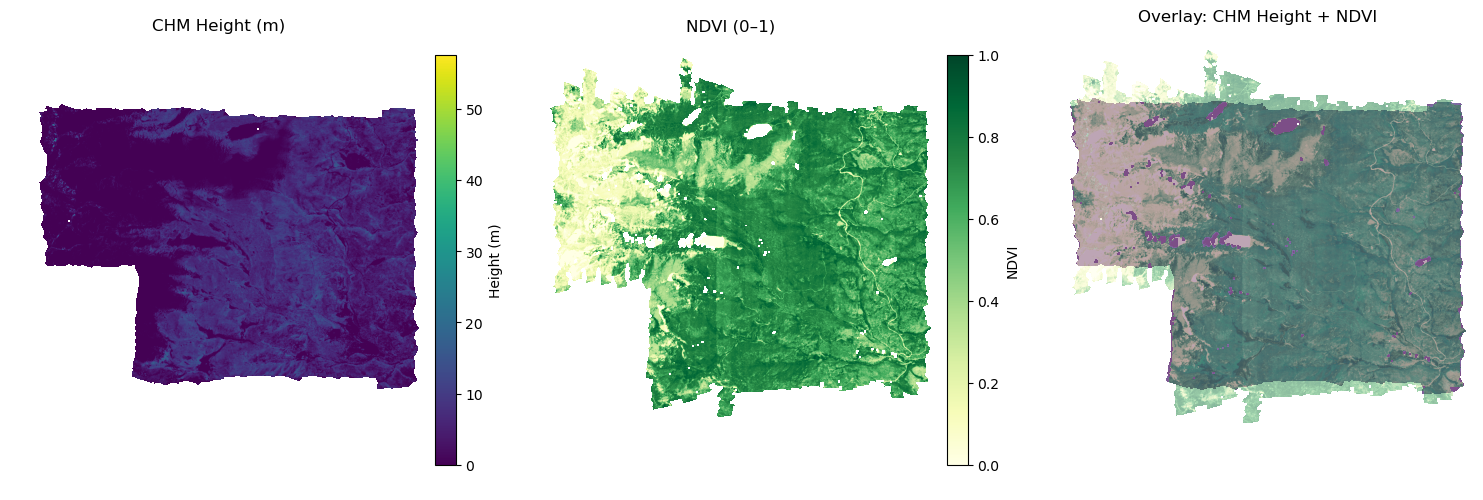

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent

site = "NIWO"
year = "2020"

# paths to your already-aligned CHM and vegetation-index mosaics
chm_root    = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
veg_aligned = r"D:/MSDS/MSDS 696_Practicum II/veg_aligned"

chm_fp  = os.path.join(chm_root,  site, f"{site}_CHM_{year}_aligned.tif")
ndvi_fp = os.path.join(veg_aligned, site, year, f"{site}_{year}_NDVI_mos.tif")

# downsample factor (to speed plotting & reduce memory)
factor = 10

def read_downsample(path, factor):
    with rasterio.open(path) as src:
        out_h = src.height // factor
        out_w = src.width  // factor
        arr = src.read(
            1,
            out_shape=(out_h, out_w),
            resampling=Resampling.average
        ).astype("float32")
        nod = src.nodata if src.nodata is not None else np.nan
        arr = np.ma.masked_where(arr == nod, arr)
        ext = plotting_extent(src)
    return arr, ext

# 1) read & downsample
chm_ds,  chm_ext  = read_downsample(chm_fp,  factor)
ndvi_ds, ndvi_ext = read_downsample(ndvi_fp, factor)

# 2) side-by-side + overlay in one figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# CHM Height panel (no negative values)
im1 = ax1.imshow(chm_ds, extent=chm_ext, cmap="viridis", origin="upper")
ax1.set_title("CHM Height (m)")
ax1.axis("off")
c1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
c1.set_label("Height (m)")

# NDVI panel
im2 = ax2.imshow(ndvi_ds, extent=ndvi_ext, cmap="YlGn", vmin=0, vmax=1, origin="upper")
ax2.set_title("NDVI (0–1)")
ax2.axis("off")
c2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
c2.set_label("NDVI")

# Overlay panel
ax3.imshow(chm_ds,  extent=chm_ext, cmap="viridis", alpha=0.7, origin="upper")
ax3.imshow(ndvi_ds, extent=ndvi_ext, cmap="YlGn",    vmin=0, vmax=1, alpha=0.5, origin="upper")
ax3.set_title("Overlay: CHM Height + NDVI")
ax3.axis("off")

plt.tight_layout()
plt.show()
plt.close(fig)

#### What to look for and potential issues

- **Co-registration:**  
  Key ridges, valleys and vegetation patterns should fall in the same places on both panels.  

- **“Extra” NDVI pixels:**  
  You’ll notice green NDVI areas extending beyond the yellow/white CHM Δ footprint. This occurs because the spectrometer fly-swath covers a slightly larger area than the region where we computed ΔCHM (i.e., where we have both a reference and a comparison LiDAR flight).  

- **Is this a problem?**  
  Not necessarily—but it *does* mean that some NDVI pixels sit outside our ΔCHM domain. If we blindly extract features over the full NDVI extent, we’ll introduce spurious “no-data” or mismatched areas into our training table.  

- **Next Step:**  
  Mask all vegetation-index rasters to the CHM Δ extent (or vice versa) so that every feature row corresponds to a location where we have both structural (ΔCHM) and spectral (NDVI, etc.) information.  

### Step 3: Mask Vegetation Rasters to CHM Coverage

Before we extract combined structural (Δ CHM) and spectral (NDVI, EVI, …) features, we need to ensure every pixel has both values. Here we:

1. Load the aligned CHM-difference raster and each vegetation-index mosaic (e.g. NDVI).  
2. Build a boolean mask of “valid” pixels where CHM ≠ nodata and VI ≠ nodata.  
3. Apply that common mask to the VI (and optionally to the CHM) so that downstream feature tables only include pixels with both structural and spectral data.  
4. Write out the masked VI rasters for use in feature extraction.  

In [35]:
# 3) Mask each Vegetation Index to the CHM diff valid area
veg_masked_root = veg_aligned.replace("veg_aligned", "veg_masked")
os.makedirs(veg_masked_root, exist_ok=True)

INDICES = ["NDVI","EVI","ARVI","PRI","SAVI"]
for site in site_codes:
    chm_diff_dir = os.path.join(chm_root, site, "differences")
    veg_site_dir = os.path.join(veg_aligned, site)
    for year in sorted(os.listdir(veg_site_dir)):
        chm_diff_fp = os.path.join(chm_diff_dir, f"{site}_CHM_{year}_diff.tif")
        if not os.path.exists(chm_diff_fp):
            continue
        for idx in INDICES:
            veg_fp = os.path.join(veg_site_dir, year, f"{site}_{year}_{idx}_mos.tif")
            if not os.path.exists(veg_fp):
                continue

            # read CHM diff and VI
            with rasterio.open(chm_diff_fp) as chm_src, rasterio.open(veg_fp) as vi_src:
                chm = chm_src.read(1)
                vi  = vi_src.read(1)
                chm_nodata = chm_src.nodata if chm_src.nodata is not None else np.nan
                vi_nodata  = vi_src.nodata  if vi_src.nodata  is not None else np.nan

                # valid mask: both CHM and VI have data
                valid = (chm != chm_nodata) & (vi != vi_nodata)

                # mask VI outside CHM coverage
                vi_masked = np.where(valid, vi, vi_nodata)

                # update metadata and write masked VI
                out_dir = os.path.join(veg_masked_root, site, year)
                os.makedirs(out_dir, exist_ok=True)
                out_fp = os.path.join(out_dir, f"{site}_{year}_{idx}_masked.tif")

                meta = vi_src.meta.copy()
                meta.update({"nodata": vi_nodata})

                with rasterio.open(out_fp, "w", **meta) as dst:
                    dst.write(vi_masked, 1)

            print(f"✅ Masked {idx} → {os.path.relpath(out_fp, veg_masked_root)}")

✅ Masked NDVI → NIWO\2018\NIWO_2018_NDVI_masked.tif
✅ Masked EVI → NIWO\2018\NIWO_2018_EVI_masked.tif
✅ Masked ARVI → NIWO\2018\NIWO_2018_ARVI_masked.tif
✅ Masked PRI → NIWO\2018\NIWO_2018_PRI_masked.tif
✅ Masked SAVI → NIWO\2018\NIWO_2018_SAVI_masked.tif
✅ Masked NDVI → NIWO\2019\NIWO_2019_NDVI_masked.tif
✅ Masked EVI → NIWO\2019\NIWO_2019_EVI_masked.tif
✅ Masked ARVI → NIWO\2019\NIWO_2019_ARVI_masked.tif
✅ Masked PRI → NIWO\2019\NIWO_2019_PRI_masked.tif
✅ Masked SAVI → NIWO\2019\NIWO_2019_SAVI_masked.tif
✅ Masked NDVI → NIWO\2020\NIWO_2020_NDVI_masked.tif
✅ Masked EVI → NIWO\2020\NIWO_2020_EVI_masked.tif
✅ Masked ARVI → NIWO\2020\NIWO_2020_ARVI_masked.tif
✅ Masked PRI → NIWO\2020\NIWO_2020_PRI_masked.tif
✅ Masked SAVI → NIWO\2020\NIWO_2020_SAVI_masked.tif
✅ Masked NDVI → WLOU\2019\WLOU_2019_NDVI_masked.tif
✅ Masked EVI → WLOU\2019\WLOU_2019_EVI_masked.tif
✅ Masked ARVI → WLOU\2019\WLOU_2019_ARVI_masked.tif
✅ Masked PRI → WLOU\2019\WLOU_2019_PRI_masked.tif
✅ Masked SAVI → WLOU\2019\WL

#### Visual Alignment of CHM and NDVI After Masking

This figure shows (1) canopy height (CHM) in meters, (2) NDVI (0–1), and (3) their semi-transparent overlay:

- Tall, healthy forest (high CHM + high NDVI) appears greenish.  
- Sparse or non-vegetated areas (low CHM + low NDVI) appear purple-grey.  
- Masking ensures only pixels with both CHM and NDVI are shown, so our ML features align exactly.  

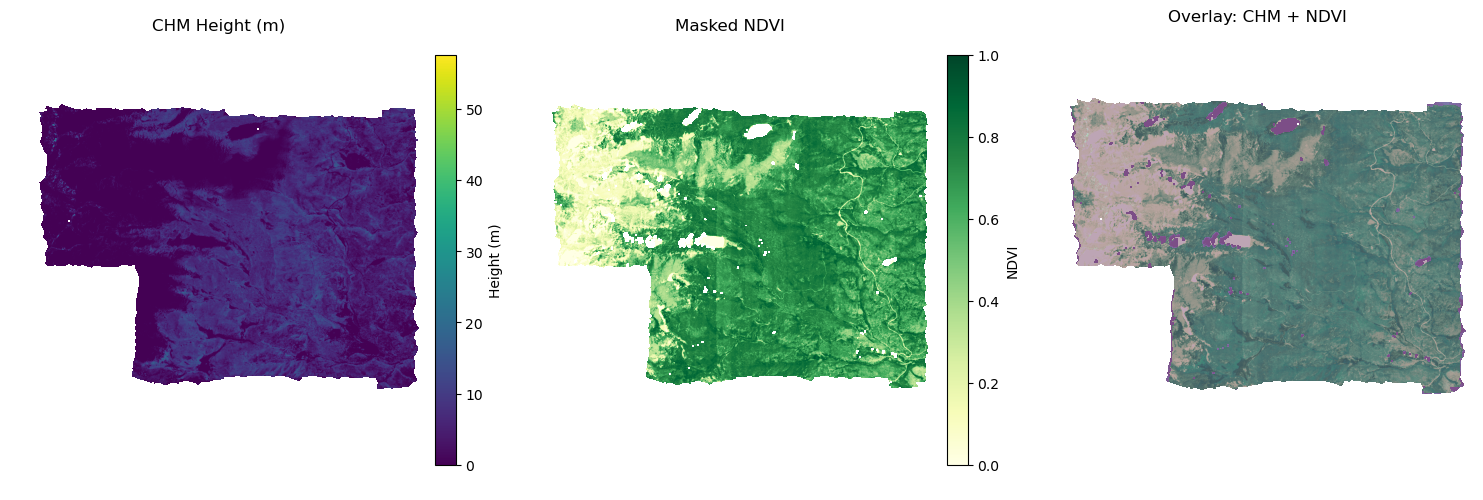

In [36]:
# read_downsample and paths assumed defined above

# switch to the masked VEG directory
veg_masked = r"D:/MSDS/MSDS 696_Practicum II/veg_masked"

site = "NIWO"
year = "2020"

chm_fp   = os.path.join(chm_root,  site, f"{site}_CHM_{year}_aligned.tif")
ndvi_fp  = os.path.join(veg_masked, site, year, f"{site}_{year}_NDVI_masked.tif")

# 1) read & downsample
chm_ds,   chm_ext  = read_downsample(chm_fp,   factor)
ndvi_ds,  ndvi_ext = read_downsample(ndvi_fp,  factor)

# 2) side-by-side + overlay
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# CHM height
im1 = ax1.imshow(chm_ds, extent=chm_ext, cmap="viridis", origin="upper")
ax1.set_title("CHM Height (m)")
ax1.axis("off")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02).set_label("Height (m)")

# Masked NDVI
im2 = ax2.imshow(ndvi_ds, extent=ndvi_ext, cmap="YlGn", vmin=0, vmax=1, origin="upper")
ax2.set_title("Masked NDVI")
ax2.axis("off")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02).set_label("NDVI")

# Overlay
ax3.imshow(chm_ds,  extent=chm_ext, cmap="viridis", alpha=0.7, origin="upper")
ax3.imshow(ndvi_ds, extent=ndvi_ext, cmap="YlGn",    vmin=0, vmax=1, alpha=0.5, origin="upper")
ax3.set_title("Overlay: CHM + NDVI")
ax3.axis("off")

plt.tight_layout()
plt.show()
plt.close(fig)

## Phase 2: Feature Extraction

### Step 1: Block-Level Feature Extraction Using Fixed Thresholds (±2 m)

This step extracts block-level features from canopy height model difference (CHM-Δ) rasters using fixed thresholds to classify vegetation change. Each CHM-Δ raster is divided into 100×100 pixel blocks, and for each block, we compute the proportion of pixels falling into three change classes:

- **Loss**: CHM-Δ < -2.0 meters  
- **Stable**: -2.0 ≤ CHM-Δ ≤ 2.0 meters  
- **Gain**: CHM-Δ > 2.0 meters  

In addition to class proportions, we compute summary statistics such as the **mean** and **standard deviation** of CHM-Δ values for each block. We also extract the mean values of multiple vegetation indices (e.g., NDVI, EVI, ARVI, PRI, SAVI) from corresponding vegetation raster layers.

This process is performed in parallel using multithreading to accelerate block-wise analysis across multiple site-year combinations. While efficient, this fixed-threshold approach may still lead to class imbalance in the resulting dataset, as many blocks do not meet the ±2 m change cutoff.

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm


# Parameters
chm_root        = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
veg_masked_root = r"D:/MSDS/MSDS 696_Practicum II/veg_masked"
site_codes      = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]
INDICES         = ["NDVI","EVI","ARVI","PRI","SAVI"]
loss_thr, gain_thr = -2.0, 2.0
BLOCK_PIXELS    = 100
MAX_WORKERS     = 8


# collect (chm_fp, window, site, year)
jobs = []
for site in site_codes:
    diff_dir = os.path.join(chm_root, site, "differences")
    if not os.path.isdir(diff_dir):
        continue

    for fname in os.listdir(diff_dir):
        if not fname.endswith("_diff.tif"):
            continue
        year   = int(fname.split("_")[-2])
        chm_fp = os.path.join(diff_dir, fname)

        with rasterio.open(chm_fp) as src:
            for ji, win in src.block_windows(1):
                jobs.append((chm_fp, win, site, year))

# worker function
def process_window(args):
    chm_fp, win, site, year = args
    with rasterio.open(chm_fp) as chm_src:
        block = chm_src.read(1, window=win).astype("float32")
        nod   = chm_src.nodata if chm_src.nodata is not None else -9999
        valid = block != nod
        if valid.sum() < BLOCK_PIXELS * BLOCK_PIXELS * 0.5:
            return None
        vals = block[valid]

    rec = {
        "site": site, "year": year,
        "row_off": win.row_off, "col_off": win.col_off,
        "chm_pct_loss":   (vals <  loss_thr).sum() / valid.sum() * 100,
        "chm_pct_stable": ((vals >= loss_thr)&(vals <= gain_thr)).sum() / valid.sum() * 100,
        "chm_pct_gain":   (vals >  gain_thr).sum() / valid.sum() * 100,
        "chm_mean_diff":  float(vals.mean()),
        "chm_std_diff":   float(vals.std()),
    }

    # extract mean of each masked VI
    for idx in INDICES:
        vi_fp = os.path.join(veg_masked_root, site, str(year), f"{site}_{year}_{idx}_masked.tif")
        if not os.path.exists(vi_fp):
            rec[f"{idx}_mean"] = np.nan
            continue
        with rasterio.open(vi_fp) as vi_src:
            vi_block = vi_src.read(1, window=win).astype("float32")
            vn       = vi_src.nodata if vi_src.nodata is not None else np.nan
            mask_vi  = (vi_block != vn) & np.isfinite(vi_block)
            rec[f"{idx}_mean"] = float(vi_block[mask_vi].mean()) if mask_vi.sum() else np.nan

    return rec

# parallel processing
records = []
seen_site_year = set()

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as exe:
    futures = {exe.submit(process_window, job): job for job in jobs}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Blocks"):
        chm_fp, win, site, year = futures[future]
        # print a one-line header the first time we hit each site/year
        if (site, year) not in seen_site_year:
            print(f"\n→ Processing {site} {year} …")
            seen_site_year.add((site, year))

        result = future.result()
        if result:
            records.append(result)

# assemble and save
df_blocks = pd.DataFrame(records)
out_csv   = os.path.join(veg_masked_root, "block_level_features.csv")
df_blocks.to_csv(out_csv, index=False)
print(f"\n✅ Block-level features saved ({len(df_blocks)} rows) → {out_csv}")

In [148]:
# read level csv
df_blocks = pd.read_csv(r"D:/MSDS/MSDS 696_Practicum II/veg_masked/block_level_features.csv")
print(df.shape)
print(df.head())

(230218, 14)
   site  year  row_off  col_off  chm_pct_loss  chm_pct_stable  chm_pct_gain  \
0  NIWO  2018     2216        0      1.450326       93.944888      4.604786   
1  NIWO  2018     2212        0      0.948804       94.366476      4.684720   
2  NIWO  2018     2219        0      1.358204       93.879029      4.762767   
3  NIWO  2018     2214        0      1.102333       94.322984      4.574683   
4  NIWO  2018     2215        0      1.254774       93.798873      4.946354   

   chm_mean_diff  chm_std_diff  NDVI_mean  EVI_mean  ARVI_mean  PRI_mean  \
0       0.258426      1.225050   0.287421  0.171074   0.169000 -0.062316   
1       0.242760      1.017283   0.297499  0.177484   0.180416 -0.062205   
2       0.265007      1.352715   0.291226  0.174802   0.173225 -0.062464   
3       0.243309      1.140815   0.286615  0.171286   0.168252 -0.062654   
4       0.251284      1.111125   0.288483  0.172530   0.169967 -0.062567   

   SAVI_mean  
0   0.162496  
1   0.168333  
2   0.1656

In [150]:
# 1) Define each block’s change‐class by whichever percent is highest
df_blocks["class"] = (
    df_blocks[["chm_pct_loss","chm_pct_stable","chm_pct_gain"]]
      .idxmax(axis=1)              # returns “chm_pct_loss” etc.
      .str.replace("chm_pct_","")   # → “loss” / “stable” / “gain”
      .str.capitalize()             # → “Loss” / “Stable” / “Gain”
)

# 2) Quick check of class balance
print(df_blocks["class"].value_counts(normalize=True) * 100)

class
Stable    100.0
Name: proportion, dtype: float64


In [152]:
# how many blocks have at least one pixel with >2 m gain or <–2 m loss?
n_blocks = len(df_blocks)
has_loss = (df_blocks["chm_pct_loss"] > 0).sum()
has_gain = (df_blocks["chm_pct_gain"] > 0).sum()
print(f"Out of {n_blocks} blocks:")
print(f"  blocks with any loss (>2 m): {has_loss} ({has_loss/n_blocks*100:.2f} %)")
print(f"  blocks with any gain (>2 m): {has_gain} ({has_gain/n_blocks*100:.2f} %)")

Out of 230218 blocks:
  blocks with any loss (>2 m): 164511 (71.46 %)
  blocks with any gain (>2 m): 214146 (93.02 %)


#### Addressing Class Imbalance from Fixed Thresholding

Using a fixed threshold of ±2 meters to classify canopy height change (CHM-Δ) into `Loss`, `Stable`, and `Gain` categories resulted in a significant class imbalance. The majority of blocks were labeled as `Stable`, while relatively few met the fixed criteria for `Loss` or `Gain`. 

This imbalance arises because many ecosystems have low year-to-year canopy variability, meaning few blocks exceed the ±2 m change cutoff, even in areas that experience subtle but ecologically important shifts.

To improve label diversity and model sensitivity, we move to a **dynamic thresholding approach**, where per-raster thresholds are computed based on the 1st and 99th percentiles of valid CHM-Δ values. This adaptive method accounts for spatial and temporal variability in vegetation structure, allowing us to more accurately identify relative disturbances across different NEON sites and years.


### Step 3: Block-Level Feature Extraction with Dynamic Thresholds

This step computes canopy height change metrics and vegetation index statistics at a fine spatial resolution (25×25 pixel blocks) across multiple NEON sites and years. For each block:

- The **CHM-Δ raster** is divided into smaller windows.
- **Dynamic thresholds** for canopy gain and loss are calculated using the 1st and 99th percentiles of CHM-Δ values per site-year.
- Each block is labeled with:
  - The percentage of pixels showing **loss**, **stable**, or **gain** canopy height.
  - The **mean** and **standard deviation** of CHM-Δ values.
- **Mean vegetation index values** (e.g., NDVI, EVI) are also computed per block using co-registered masked rasters.
- Records are skipped if they contain mostly no-data pixels to ensure quality.

The result is a large block-level dataset capturing spatiotemporal patterns in vegetation structure and condition, exported as `block_level_

In [59]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.enums import Resampling
from tqdm import tqdm

# PARAMETERS
chm_root        = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
veg_masked_root = r"D:/MSDS/MSDS 696_Practicum II/veg_masked"
site_codes      = ["NIWO", "WLOU", "STER", "RMNP", "CPER", "ARIK"]
INDICES         = ["NDVI", "EVI", "ARVI", "PRI", "SAVI"]
BLOCK_PIXELS    = 25  # Smaller blocks for finer granularity

# Build list of all (site,year,diff_fp) to process
jobs = []
for site in site_codes:
    diff_dir = os.path.join(chm_root, site, "differences")
    if not os.path.isdir(diff_dir): continue
    for fn in os.listdir(diff_dir):
        if fn.endswith("_diff.tif"):
            year = int(fn.split("_")[-2])
            jobs.append((site, year, os.path.join(diff_dir, fn)))

# Outer loop over every site-year
all_recs = []
for job_idx, (site, year, chm_fp) in enumerate(tqdm(jobs, desc="Site-Year blocks", unit="job")):
    try:
        with rasterio.open(chm_fp) as chm_src:
            full_arr = chm_src.read(1)
            nod = chm_src.nodata if chm_src.nodata is not None else -9999
            valid_full = full_arr != nod

            # Compute per-raster (site/year) thresholds
            loss_thr, gain_thr = np.percentile(full_arr[valid_full], [1, 99])

            h, w = chm_src.height, chm_src.width
            wins = [
                rasterio.windows.Window(j, i,
                    min(BLOCK_PIXELS, w-j), min(BLOCK_PIXELS, h-i))
                for i in range(0, h, BLOCK_PIXELS)
                for j in range(0, w, BLOCK_PIXELS)
            ]

            for i, win in enumerate(wins):
                if i % 100 == 0:
                    print(f"[{site} {year}] Processed {i}/{len(wins)} blocks...")

                block = chm_src.read(1, window=win)
                valid = block != nod
                if valid.sum() < 0.5 * (BLOCK_PIXELS ** 2):
                    continue

                vals = block[valid]
                rec = {
                    "site": site, "year": year,
                    "row_off": win.row_off, "col_off": win.col_off,
                    "loss_thr": loss_thr,
                    "gain_thr": gain_thr,
                    "chm_pct_loss": (vals < loss_thr).sum() / valid.sum() * 100,
                    "chm_pct_stable": ((vals >= loss_thr) & (vals <= gain_thr)).sum() / valid.sum() * 100,
                    "chm_pct_gain": (vals > gain_thr).sum() / valid.sum() * 100,
                    "chm_mean_diff": vals.mean(),
                    "chm_std_diff": vals.std()
                }

                # Read vegetation indices
                for idx in INDICES:
                    vi_fp = os.path.join(veg_masked_root, site, str(year), f"{site}_{year}_{idx}_masked.tif")
                    if os.path.exists(vi_fp):
                        with rasterio.open(vi_fp) as src:
                            vb = src.read(1, window=win)
                            vn = src.nodata if src.nodata is not None else np.nan
                            mask = vb != vn
                            rec[f"{idx}_mean"] = np.nan if mask.sum() == 0 else vb[mask].mean()
                    else:
                        rec[f"{idx}_mean"] = np.nan

                all_recs.append(rec)

        # Optional: checkpoint every site-year
        # if (job_idx + 1) % 3 == 0:
        #     pd.DataFrame(all_recs).to_csv("checkpoint.csv", index=False)
        #     print(f"[Checkpoint] Saved {len(all_recs)} records...")

    except Exception as e:
        print(f"[ERROR] Failed {site} {year}: {e}")

# Final save
df = pd.DataFrame(all_recs)
out = r"D:/MSDS/MSDS 696_Practicum II/block_level_features.csv"
df.to_csv(out, index=False)
print("Saved", out, "→", df.shape, "rows")

Site-Year blocks:   0%|          | 0/20 [00:00<?, ?job/s]

[NIWO 2018] Processed 0/435200 blocks...
[NIWO 2018] Processed 100/435200 blocks...
[NIWO 2018] Processed 200/435200 blocks...
[NIWO 2018] Processed 300/435200 blocks...
[NIWO 2018] Processed 400/435200 blocks...
[NIWO 2018] Processed 500/435200 blocks...
[NIWO 2018] Processed 600/435200 blocks...
[NIWO 2018] Processed 700/435200 blocks...
[NIWO 2018] Processed 800/435200 blocks...
[NIWO 2018] Processed 900/435200 blocks...
[NIWO 2018] Processed 1000/435200 blocks...
[NIWO 2018] Processed 1100/435200 blocks...
[NIWO 2018] Processed 1200/435200 blocks...
[NIWO 2018] Processed 1300/435200 blocks...
[NIWO 2018] Processed 1400/435200 blocks...
[NIWO 2018] Processed 1500/435200 blocks...
[NIWO 2018] Processed 1600/435200 blocks...
[NIWO 2018] Processed 1700/435200 blocks...
[NIWO 2018] Processed 1800/435200 blocks...
[NIWO 2018] Processed 1900/435200 blocks...
[NIWO 2018] Processed 2000/435200 blocks...
[NIWO 2018] Processed 2100/435200 blocks...
[NIWO 2018] Processed 2200/435200 blocks...


Site-Year blocks:   5%|▌         | 1/20 [42:44<13:32:02, 2564.34s/job]

[NIWO 2019] Processed 0/435200 blocks...
[NIWO 2019] Processed 100/435200 blocks...
[NIWO 2019] Processed 200/435200 blocks...
[NIWO 2019] Processed 300/435200 blocks...
[NIWO 2019] Processed 400/435200 blocks...
[NIWO 2019] Processed 500/435200 blocks...
[NIWO 2019] Processed 600/435200 blocks...
[NIWO 2019] Processed 700/435200 blocks...
[NIWO 2019] Processed 800/435200 blocks...
[NIWO 2019] Processed 900/435200 blocks...
[NIWO 2019] Processed 1000/435200 blocks...
[NIWO 2019] Processed 1100/435200 blocks...
[NIWO 2019] Processed 1200/435200 blocks...
[NIWO 2019] Processed 1300/435200 blocks...
[NIWO 2019] Processed 1400/435200 blocks...
[NIWO 2019] Processed 1500/435200 blocks...
[NIWO 2019] Processed 1600/435200 blocks...
[NIWO 2019] Processed 1700/435200 blocks...
[NIWO 2019] Processed 1800/435200 blocks...
[NIWO 2019] Processed 1900/435200 blocks...
[NIWO 2019] Processed 2000/435200 blocks...
[NIWO 2019] Processed 2100/435200 blocks...
[NIWO 2019] Processed 2200/435200 blocks...


Site-Year blocks:  10%|█         | 2/20 [1:22:11<12:14:31, 2448.41s/job]

[NIWO 2019] Processed 434800/435200 blocks...
[NIWO 2019] Processed 434900/435200 blocks...
[NIWO 2019] Processed 435000/435200 blocks...
[NIWO 2019] Processed 435100/435200 blocks...
[NIWO 2020] Processed 0/435200 blocks...
[NIWO 2020] Processed 100/435200 blocks...
[NIWO 2020] Processed 200/435200 blocks...
[NIWO 2020] Processed 300/435200 blocks...
[NIWO 2020] Processed 400/435200 blocks...
[NIWO 2020] Processed 500/435200 blocks...
[NIWO 2020] Processed 600/435200 blocks...
[NIWO 2020] Processed 700/435200 blocks...
[NIWO 2020] Processed 800/435200 blocks...
[NIWO 2020] Processed 900/435200 blocks...
[NIWO 2020] Processed 1000/435200 blocks...
[NIWO 2020] Processed 1100/435200 blocks...
[NIWO 2020] Processed 1200/435200 blocks...
[NIWO 2020] Processed 1300/435200 blocks...
[NIWO 2020] Processed 1400/435200 blocks...
[NIWO 2020] Processed 1500/435200 blocks...
[NIWO 2020] Processed 1600/435200 blocks...
[NIWO 2020] Processed 1700/435200 blocks...
[NIWO 2020] Processed 1800/435200 bl

Site-Year blocks:  15%|█▌        | 3/20 [2:00:55<11:17:34, 2391.42s/job]

[NIWO 2023] Processed 0/435200 blocks...
[NIWO 2023] Processed 100/435200 blocks...
[NIWO 2023] Processed 200/435200 blocks...
[NIWO 2023] Processed 300/435200 blocks...
[NIWO 2023] Processed 400/435200 blocks...
[NIWO 2023] Processed 500/435200 blocks...
[NIWO 2023] Processed 600/435200 blocks...
[NIWO 2023] Processed 700/435200 blocks...
[NIWO 2023] Processed 800/435200 blocks...
[NIWO 2023] Processed 900/435200 blocks...
[NIWO 2023] Processed 1000/435200 blocks...
[NIWO 2023] Processed 1100/435200 blocks...
[NIWO 2023] Processed 1200/435200 blocks...
[NIWO 2023] Processed 1300/435200 blocks...
[NIWO 2023] Processed 1400/435200 blocks...
[NIWO 2023] Processed 1500/435200 blocks...
[NIWO 2023] Processed 1600/435200 blocks...
[NIWO 2023] Processed 1700/435200 blocks...
[NIWO 2023] Processed 1800/435200 blocks...
[NIWO 2023] Processed 1900/435200 blocks...
[NIWO 2023] Processed 2000/435200 blocks...
[NIWO 2023] Processed 2100/435200 blocks...
[NIWO 2023] Processed 2200/435200 blocks...


Site-Year blocks:  20%|██        | 4/20 [2:02:14<6:34:20, 1478.75s/job] 

[WLOU 2019] Processed 0/102400 blocks...
[WLOU 2019] Processed 100/102400 blocks...
[WLOU 2019] Processed 200/102400 blocks...
[WLOU 2019] Processed 300/102400 blocks...
[WLOU 2019] Processed 400/102400 blocks...
[WLOU 2019] Processed 500/102400 blocks...
[WLOU 2019] Processed 600/102400 blocks...
[WLOU 2019] Processed 700/102400 blocks...
[WLOU 2019] Processed 800/102400 blocks...
[WLOU 2019] Processed 900/102400 blocks...
[WLOU 2019] Processed 1000/102400 blocks...
[WLOU 2019] Processed 1100/102400 blocks...
[WLOU 2019] Processed 1200/102400 blocks...
[WLOU 2019] Processed 1300/102400 blocks...
[WLOU 2019] Processed 1400/102400 blocks...
[WLOU 2019] Processed 1500/102400 blocks...
[WLOU 2019] Processed 1600/102400 blocks...
[WLOU 2019] Processed 1700/102400 blocks...
[WLOU 2019] Processed 1800/102400 blocks...
[WLOU 2019] Processed 1900/102400 blocks...
[WLOU 2019] Processed 2000/102400 blocks...
[WLOU 2019] Processed 2100/102400 blocks...
[WLOU 2019] Processed 2200/102400 blocks...


Site-Year blocks:  25%|██▌       | 5/20 [2:09:35<4:36:06, 1104.44s/job]

[WLOU 2019] Processed 100000/102400 blocks...
[WLOU 2019] Processed 100100/102400 blocks...
[WLOU 2019] Processed 100200/102400 blocks...
[WLOU 2019] Processed 100300/102400 blocks...
[WLOU 2019] Processed 100400/102400 blocks...
[WLOU 2019] Processed 100500/102400 blocks...
[WLOU 2019] Processed 100600/102400 blocks...
[WLOU 2019] Processed 100700/102400 blocks...
[WLOU 2019] Processed 100800/102400 blocks...
[WLOU 2019] Processed 100900/102400 blocks...
[WLOU 2019] Processed 101000/102400 blocks...
[WLOU 2019] Processed 101100/102400 blocks...
[WLOU 2019] Processed 101200/102400 blocks...
[WLOU 2019] Processed 101300/102400 blocks...
[WLOU 2019] Processed 101400/102400 blocks...
[WLOU 2019] Processed 101500/102400 blocks...
[WLOU 2019] Processed 101600/102400 blocks...
[WLOU 2019] Processed 101700/102400 blocks...
[WLOU 2019] Processed 101800/102400 blocks...
[WLOU 2019] Processed 101900/102400 blocks...
[WLOU 2019] Processed 102000/102400 blocks...
[WLOU 2019] Processed 102100/10240

Site-Year blocks:  30%|███       | 6/20 [2:16:07<3:21:08, 862.05s/job] 

[WLOU 2023] Processed 0/102400 blocks...
[WLOU 2023] Processed 100/102400 blocks...
[WLOU 2023] Processed 200/102400 blocks...
[WLOU 2023] Processed 300/102400 blocks...
[WLOU 2023] Processed 400/102400 blocks...
[WLOU 2023] Processed 500/102400 blocks...
[WLOU 2023] Processed 600/102400 blocks...
[WLOU 2023] Processed 700/102400 blocks...
[WLOU 2023] Processed 800/102400 blocks...
[WLOU 2023] Processed 900/102400 blocks...
[WLOU 2023] Processed 1000/102400 blocks...
[WLOU 2023] Processed 1100/102400 blocks...
[WLOU 2023] Processed 1200/102400 blocks...
[WLOU 2023] Processed 1300/102400 blocks...
[WLOU 2023] Processed 1400/102400 blocks...
[WLOU 2023] Processed 1500/102400 blocks...
[WLOU 2023] Processed 1600/102400 blocks...
[WLOU 2023] Processed 1700/102400 blocks...
[WLOU 2023] Processed 1800/102400 blocks...
[WLOU 2023] Processed 1900/102400 blocks...
[WLOU 2023] Processed 2000/102400 blocks...
[WLOU 2023] Processed 2100/102400 blocks...
[WLOU 2023] Processed 2200/102400 blocks...


Site-Year blocks:  35%|███▌      | 7/20 [2:16:23<2:06:51, 585.47s/job]

[STER 2017] Processed 0/134400 blocks...
[STER 2017] Processed 100/134400 blocks...
[STER 2017] Processed 200/134400 blocks...
[STER 2017] Processed 300/134400 blocks...
[STER 2017] Processed 400/134400 blocks...
[STER 2017] Processed 500/134400 blocks...
[STER 2017] Processed 600/134400 blocks...
[STER 2017] Processed 700/134400 blocks...
[STER 2017] Processed 800/134400 blocks...
[STER 2017] Processed 900/134400 blocks...
[STER 2017] Processed 1000/134400 blocks...
[STER 2017] Processed 1100/134400 blocks...
[STER 2017] Processed 1200/134400 blocks...
[STER 2017] Processed 1300/134400 blocks...
[STER 2017] Processed 1400/134400 blocks...
[STER 2017] Processed 1500/134400 blocks...
[STER 2017] Processed 1600/134400 blocks...
[STER 2017] Processed 1700/134400 blocks...
[STER 2017] Processed 1800/134400 blocks...
[STER 2017] Processed 1900/134400 blocks...
[STER 2017] Processed 2000/134400 blocks...
[STER 2017] Processed 2100/134400 blocks...
[STER 2017] Processed 2200/134400 blocks...


Site-Year blocks:  40%|████      | 8/20 [2:33:03<2:23:30, 717.57s/job]

[STER 2017] Processed 133300/134400 blocks...
[STER 2017] Processed 133400/134400 blocks...
[STER 2017] Processed 133500/134400 blocks...
[STER 2017] Processed 133600/134400 blocks...
[STER 2017] Processed 133700/134400 blocks...
[STER 2017] Processed 133800/134400 blocks...
[STER 2017] Processed 133900/134400 blocks...
[STER 2017] Processed 134000/134400 blocks...
[STER 2017] Processed 134100/134400 blocks...
[STER 2017] Processed 134200/134400 blocks...
[STER 2017] Processed 134300/134400 blocks...
[STER 2021] Processed 0/134400 blocks...
[STER 2021] Processed 100/134400 blocks...
[STER 2021] Processed 200/134400 blocks...
[STER 2021] Processed 300/134400 blocks...
[STER 2021] Processed 400/134400 blocks...
[STER 2021] Processed 500/134400 blocks...
[STER 2021] Processed 600/134400 blocks...
[STER 2021] Processed 700/134400 blocks...
[STER 2021] Processed 800/134400 blocks...
[STER 2021] Processed 900/134400 blocks...
[STER 2021] Processed 1000/134400 blocks...
[STER 2021] Processed 

Site-Year blocks:  45%|████▌     | 9/20 [2:33:35<1:32:14, 503.14s/job]

[STER 2022] Processed 0/134400 blocks...
[STER 2022] Processed 100/134400 blocks...
[STER 2022] Processed 200/134400 blocks...
[STER 2022] Processed 300/134400 blocks...
[STER 2022] Processed 400/134400 blocks...
[STER 2022] Processed 500/134400 blocks...
[STER 2022] Processed 600/134400 blocks...
[STER 2022] Processed 700/134400 blocks...
[STER 2022] Processed 800/134400 blocks...
[STER 2022] Processed 900/134400 blocks...
[STER 2022] Processed 1000/134400 blocks...
[STER 2022] Processed 1100/134400 blocks...
[STER 2022] Processed 1200/134400 blocks...
[STER 2022] Processed 1300/134400 blocks...
[STER 2022] Processed 1400/134400 blocks...
[STER 2022] Processed 1500/134400 blocks...
[STER 2022] Processed 1600/134400 blocks...
[STER 2022] Processed 1700/134400 blocks...
[STER 2022] Processed 1800/134400 blocks...
[STER 2022] Processed 1900/134400 blocks...
[STER 2022] Processed 2000/134400 blocks...
[STER 2022] Processed 2100/134400 blocks...
[STER 2022] Processed 2200/134400 blocks...


Site-Year blocks:  50%|█████     | 10/20 [2:34:06<59:34, 357.43s/job] 

[RMNP 2018] Processed 0/457600 blocks...
[RMNP 2018] Processed 100/457600 blocks...
[RMNP 2018] Processed 200/457600 blocks...
[RMNP 2018] Processed 300/457600 blocks...
[RMNP 2018] Processed 400/457600 blocks...
[RMNP 2018] Processed 500/457600 blocks...
[RMNP 2018] Processed 600/457600 blocks...
[RMNP 2018] Processed 700/457600 blocks...
[RMNP 2018] Processed 800/457600 blocks...
[RMNP 2018] Processed 900/457600 blocks...
[RMNP 2018] Processed 1000/457600 blocks...
[RMNP 2018] Processed 1100/457600 blocks...
[RMNP 2018] Processed 1200/457600 blocks...
[RMNP 2018] Processed 1300/457600 blocks...
[RMNP 2018] Processed 1400/457600 blocks...
[RMNP 2018] Processed 1500/457600 blocks...
[RMNP 2018] Processed 1600/457600 blocks...
[RMNP 2018] Processed 1700/457600 blocks...
[RMNP 2018] Processed 1800/457600 blocks...
[RMNP 2018] Processed 1900/457600 blocks...
[RMNP 2018] Processed 2000/457600 blocks...
[RMNP 2018] Processed 2100/457600 blocks...
[RMNP 2018] Processed 2200/457600 blocks...


Site-Year blocks:  55%|█████▌    | 11/20 [4:11:55<5:06:39, 2044.34s/job]

[RMNP 2020] Processed 0/457600 blocks...
[RMNP 2020] Processed 100/457600 blocks...
[RMNP 2020] Processed 200/457600 blocks...
[RMNP 2020] Processed 300/457600 blocks...
[RMNP 2020] Processed 400/457600 blocks...
[RMNP 2020] Processed 500/457600 blocks...
[RMNP 2020] Processed 600/457600 blocks...
[RMNP 2020] Processed 700/457600 blocks...
[RMNP 2020] Processed 800/457600 blocks...
[RMNP 2020] Processed 900/457600 blocks...
[RMNP 2020] Processed 1000/457600 blocks...
[RMNP 2020] Processed 1100/457600 blocks...
[RMNP 2020] Processed 1200/457600 blocks...
[RMNP 2020] Processed 1300/457600 blocks...
[RMNP 2020] Processed 1400/457600 blocks...
[RMNP 2020] Processed 1500/457600 blocks...
[RMNP 2020] Processed 1600/457600 blocks...
[RMNP 2020] Processed 1700/457600 blocks...
[RMNP 2020] Processed 1800/457600 blocks...
[RMNP 2020] Processed 1900/457600 blocks...
[RMNP 2020] Processed 2000/457600 blocks...
[RMNP 2020] Processed 2100/457600 blocks...
[RMNP 2020] Processed 2200/457600 blocks...


Site-Year blocks:  60%|██████    | 12/20 [5:59:44<7:32:03, 3390.44s/job]

[RMNP 2022] Processed 0/457600 blocks...
[RMNP 2022] Processed 100/457600 blocks...
[RMNP 2022] Processed 200/457600 blocks...
[RMNP 2022] Processed 300/457600 blocks...
[RMNP 2022] Processed 400/457600 blocks...
[RMNP 2022] Processed 500/457600 blocks...
[RMNP 2022] Processed 600/457600 blocks...
[RMNP 2022] Processed 700/457600 blocks...
[RMNP 2022] Processed 800/457600 blocks...
[RMNP 2022] Processed 900/457600 blocks...
[RMNP 2022] Processed 1000/457600 blocks...
[RMNP 2022] Processed 1100/457600 blocks...
[RMNP 2022] Processed 1200/457600 blocks...
[RMNP 2022] Processed 1300/457600 blocks...
[RMNP 2022] Processed 1400/457600 blocks...
[RMNP 2022] Processed 1500/457600 blocks...
[RMNP 2022] Processed 1600/457600 blocks...
[RMNP 2022] Processed 1700/457600 blocks...
[RMNP 2022] Processed 1800/457600 blocks...
[RMNP 2022] Processed 1900/457600 blocks...
[RMNP 2022] Processed 2000/457600 blocks...
[RMNP 2022] Processed 2100/457600 blocks...
[RMNP 2022] Processed 2200/457600 blocks...


Site-Year blocks:  65%|██████▌   | 13/20 [6:01:26<4:39:19, 2394.28s/job]

[RMNP 2023] Processed 0/457600 blocks...
[RMNP 2023] Processed 100/457600 blocks...
[RMNP 2023] Processed 200/457600 blocks...
[RMNP 2023] Processed 300/457600 blocks...
[RMNP 2023] Processed 400/457600 blocks...
[RMNP 2023] Processed 500/457600 blocks...
[RMNP 2023] Processed 600/457600 blocks...
[RMNP 2023] Processed 700/457600 blocks...
[RMNP 2023] Processed 800/457600 blocks...
[RMNP 2023] Processed 900/457600 blocks...
[RMNP 2023] Processed 1000/457600 blocks...
[RMNP 2023] Processed 1100/457600 blocks...
[RMNP 2023] Processed 1200/457600 blocks...
[RMNP 2023] Processed 1300/457600 blocks...
[RMNP 2023] Processed 1400/457600 blocks...
[RMNP 2023] Processed 1500/457600 blocks...
[RMNP 2023] Processed 1600/457600 blocks...
[RMNP 2023] Processed 1700/457600 blocks...
[RMNP 2023] Processed 1800/457600 blocks...
[RMNP 2023] Processed 1900/457600 blocks...
[RMNP 2023] Processed 2000/457600 blocks...
[RMNP 2023] Processed 2100/457600 blocks...
[RMNP 2023] Processed 2200/457600 blocks...


Site-Year blocks:  70%|███████   | 14/20 [6:03:07<2:50:08, 1701.49s/job]

[CPER 2017] Processed 0/228800 blocks...
[CPER 2017] Processed 100/228800 blocks...
[CPER 2017] Processed 200/228800 blocks...
[CPER 2017] Processed 300/228800 blocks...
[CPER 2017] Processed 400/228800 blocks...
[CPER 2017] Processed 500/228800 blocks...
[CPER 2017] Processed 600/228800 blocks...
[CPER 2017] Processed 700/228800 blocks...
[CPER 2017] Processed 800/228800 blocks...
[CPER 2017] Processed 900/228800 blocks...
[CPER 2017] Processed 1000/228800 blocks...
[CPER 2017] Processed 1100/228800 blocks...
[CPER 2017] Processed 1200/228800 blocks...
[CPER 2017] Processed 1300/228800 blocks...
[CPER 2017] Processed 1400/228800 blocks...
[CPER 2017] Processed 1500/228800 blocks...
[CPER 2017] Processed 1600/228800 blocks...
[CPER 2017] Processed 1700/228800 blocks...
[CPER 2017] Processed 1800/228800 blocks...
[CPER 2017] Processed 1900/228800 blocks...
[CPER 2017] Processed 2000/228800 blocks...
[CPER 2017] Processed 2100/228800 blocks...
[CPER 2017] Processed 2200/228800 blocks...


Site-Year blocks:  75%|███████▌  | 15/20 [7:06:31<3:14:36, 2335.30s/job]

[CPER 2020] Processed 0/228800 blocks...
[CPER 2020] Processed 100/228800 blocks...
[CPER 2020] Processed 200/228800 blocks...
[CPER 2020] Processed 300/228800 blocks...
[CPER 2020] Processed 400/228800 blocks...
[CPER 2020] Processed 500/228800 blocks...
[CPER 2020] Processed 600/228800 blocks...
[CPER 2020] Processed 700/228800 blocks...
[CPER 2020] Processed 800/228800 blocks...
[CPER 2020] Processed 900/228800 blocks...
[CPER 2020] Processed 1000/228800 blocks...
[CPER 2020] Processed 1100/228800 blocks...
[CPER 2020] Processed 1200/228800 blocks...
[CPER 2020] Processed 1300/228800 blocks...
[CPER 2020] Processed 1400/228800 blocks...
[CPER 2020] Processed 1500/228800 blocks...
[CPER 2020] Processed 1600/228800 blocks...
[CPER 2020] Processed 1700/228800 blocks...
[CPER 2020] Processed 1800/228800 blocks...
[CPER 2020] Processed 1900/228800 blocks...
[CPER 2020] Processed 2000/228800 blocks...
[CPER 2020] Processed 2100/228800 blocks...
[CPER 2020] Processed 2200/228800 blocks...


Site-Year blocks:  80%|████████  | 16/20 [8:11:10<3:06:39, 2799.96s/job]

[CPER 2021] Processed 0/228800 blocks...
[CPER 2021] Processed 100/228800 blocks...
[CPER 2021] Processed 200/228800 blocks...
[CPER 2021] Processed 300/228800 blocks...
[CPER 2021] Processed 400/228800 blocks...
[CPER 2021] Processed 500/228800 blocks...
[CPER 2021] Processed 600/228800 blocks...
[CPER 2021] Processed 700/228800 blocks...
[CPER 2021] Processed 800/228800 blocks...
[CPER 2021] Processed 900/228800 blocks...
[CPER 2021] Processed 1000/228800 blocks...
[CPER 2021] Processed 1100/228800 blocks...
[CPER 2021] Processed 1200/228800 blocks...
[CPER 2021] Processed 1300/228800 blocks...
[CPER 2021] Processed 1400/228800 blocks...
[CPER 2021] Processed 1500/228800 blocks...
[CPER 2021] Processed 1600/228800 blocks...
[CPER 2021] Processed 1700/228800 blocks...
[CPER 2021] Processed 1800/228800 blocks...
[CPER 2021] Processed 1900/228800 blocks...
[CPER 2021] Processed 2000/228800 blocks...
[CPER 2021] Processed 2100/228800 blocks...
[CPER 2021] Processed 2200/228800 blocks...


Site-Year blocks:  85%|████████▌ | 17/20 [8:12:00<1:38:38, 1972.93s/job]

[ARIK 2020] Processed 0/360000 blocks...
[ARIK 2020] Processed 100/360000 blocks...
[ARIK 2020] Processed 200/360000 blocks...
[ARIK 2020] Processed 300/360000 blocks...
[ARIK 2020] Processed 400/360000 blocks...
[ARIK 2020] Processed 500/360000 blocks...
[ARIK 2020] Processed 600/360000 blocks...
[ARIK 2020] Processed 700/360000 blocks...
[ARIK 2020] Processed 800/360000 blocks...
[ARIK 2020] Processed 900/360000 blocks...
[ARIK 2020] Processed 1000/360000 blocks...
[ARIK 2020] Processed 1100/360000 blocks...
[ARIK 2020] Processed 1200/360000 blocks...
[ARIK 2020] Processed 1300/360000 blocks...
[ARIK 2020] Processed 1400/360000 blocks...
[ARIK 2020] Processed 1500/360000 blocks...
[ARIK 2020] Processed 1600/360000 blocks...
[ARIK 2020] Processed 1700/360000 blocks...
[ARIK 2020] Processed 1800/360000 blocks...
[ARIK 2020] Processed 1900/360000 blocks...
[ARIK 2020] Processed 2000/360000 blocks...
[ARIK 2020] Processed 2100/360000 blocks...
[ARIK 2020] Processed 2200/360000 blocks...


Site-Year blocks:  90%|█████████ | 18/20 [10:48:33<2:20:05, 4202.58s/job]

[ARIK 2021] Processed 0/360000 blocks...
[ARIK 2021] Processed 100/360000 blocks...
[ARIK 2021] Processed 200/360000 blocks...
[ARIK 2021] Processed 300/360000 blocks...
[ARIK 2021] Processed 400/360000 blocks...
[ARIK 2021] Processed 500/360000 blocks...
[ARIK 2021] Processed 600/360000 blocks...
[ARIK 2021] Processed 700/360000 blocks...
[ARIK 2021] Processed 800/360000 blocks...
[ARIK 2021] Processed 900/360000 blocks...
[ARIK 2021] Processed 1000/360000 blocks...
[ARIK 2021] Processed 1100/360000 blocks...
[ARIK 2021] Processed 1200/360000 blocks...
[ARIK 2021] Processed 1300/360000 blocks...
[ARIK 2021] Processed 1400/360000 blocks...
[ARIK 2021] Processed 1500/360000 blocks...
[ARIK 2021] Processed 1600/360000 blocks...
[ARIK 2021] Processed 1700/360000 blocks...
[ARIK 2021] Processed 1800/360000 blocks...
[ARIK 2021] Processed 1900/360000 blocks...
[ARIK 2021] Processed 2000/360000 blocks...
[ARIK 2021] Processed 2100/360000 blocks...
[ARIK 2021] Processed 2200/360000 blocks...


Site-Year blocks:  95%|█████████▌| 19/20 [10:50:12<49:30, 2970.13s/job]  

[ARIK 2023] Processed 0/360000 blocks...
[ARIK 2023] Processed 100/360000 blocks...
[ARIK 2023] Processed 200/360000 blocks...
[ARIK 2023] Processed 300/360000 blocks...
[ARIK 2023] Processed 400/360000 blocks...
[ARIK 2023] Processed 500/360000 blocks...
[ARIK 2023] Processed 600/360000 blocks...
[ARIK 2023] Processed 700/360000 blocks...
[ARIK 2023] Processed 800/360000 blocks...
[ARIK 2023] Processed 900/360000 blocks...
[ARIK 2023] Processed 1000/360000 blocks...
[ARIK 2023] Processed 1100/360000 blocks...
[ARIK 2023] Processed 1200/360000 blocks...
[ARIK 2023] Processed 1300/360000 blocks...
[ARIK 2023] Processed 1400/360000 blocks...
[ARIK 2023] Processed 1500/360000 blocks...
[ARIK 2023] Processed 1600/360000 blocks...
[ARIK 2023] Processed 1700/360000 blocks...
[ARIK 2023] Processed 1800/360000 blocks...
[ARIK 2023] Processed 1900/360000 blocks...
[ARIK 2023] Processed 2000/360000 blocks...
[ARIK 2023] Processed 2100/360000 blocks...
[ARIK 2023] Processed 2200/360000 blocks...


Site-Year blocks: 100%|██████████| 20/20 [10:51:50<00:00, 1955.53s/job]


Saved D:/MSDS/MSDS 696_Practicum II/block_level_features.csv → (3916433, 16) rows


In [81]:
# read level csv
df = pd.read_csv(r"D:/MSDS/MSDS 696_Practicum II/block_level_features.csv")
print(df.shape)
print(df.head())

(3916433, 16)
   site  year  row_off  col_off  loss_thr  gain_thr  chm_pct_loss  \
0  NIWO  2018     1975     6800     -3.91     6.682      7.155635   
1  NIWO  2018     1975     6825     -3.91     6.682     11.383538   
2  NIWO  2018     1975     6850     -3.91     6.682     12.137681   
3  NIWO  2018     1975     6875     -3.91     6.682     11.487759   
4  NIWO  2018     1975     6900     -3.91     6.682      1.008065   

   chm_pct_stable  chm_pct_gain  chm_mean_diff  chm_std_diff  NDVI_mean  \
0       91.592129      1.252236       0.467435      3.569950   0.814263   
1       87.915937      0.700525      -0.386872      3.862227   0.801545   
2       86.775362      1.086957      -0.340315      3.913312   0.789479   
3       85.875706      2.636535      -0.389036      4.481967   0.805770   
4       98.790323      0.201613       0.002714      1.159827   0.831153   

   EVI_mean  ARVI_mean  PRI_mean  SAVI_mean  
0  0.322727   0.803964 -0.024310   0.319413  
1  0.258805   0.802199 -0.01

In [63]:
#display head
df.head()

site  year  row_off  col_off  loss_thr  gain_thr  chm_pct_loss  \
0  NIWO  2018     1975     6800     -3.91     6.682      7.155635   
1  NIWO  2018     1975     6825     -3.91     6.682     11.383538   
2  NIWO  2018     1975     6850     -3.91     6.682     12.137681   
3  NIWO  2018     1975     6875     -3.91     6.682     11.487759   
4  NIWO  2018     1975     6900     -3.91     6.682      1.008065   

   chm_pct_stable  chm_pct_gain  chm_mean_diff  chm_std_diff  NDVI_mean  \
0       91.592129      1.252236       0.467435      3.569950   0.814263   
1       87.915937      0.700525      -0.386872      3.862227   0.801545   
2       86.775362      1.086957      -0.340315      3.913312   0.789479   
3       85.875706      2.636535      -0.389036      4.481967   0.805770   
4       98.790323      0.201613       0.002714      1.159827   0.831153   

   EVI_mean  ARVI_mean  PRI_mean  SAVI_mean  
0  0.322727   0.803964 -0.024310   0.319413  
1  0.258805   0.802199 -0.017411   0.261811  
2  0.219416   0.799864 -0.015267   0.224838  
3  0.332826   0.793349 -0.033571   0.327911  
4  0.422521   0.787808 -0.072996   0.417691

## Phase 3: Class Distribution

### Filtering and Balancing Labeled Training Data

After generating block-level features using dynamic site-year thresholds, we inspected the distribution of threshold values to identify anomalies:

- Some site-years had `gain_thr` or `loss_thr` equal to **zero**, which suggests data quality issues or flat rasters.
- Histograms of CHM-Δ values for these site-years confirmed that the data lacked variation (e.g., entirely stable canopy or invalid rasters).

To ensure meaningful labels and avoid bias during training:
- **Suspect site-years** were identified and visually validated using histograms.
- These flat or broken site-years were excluded from the dataset.

We then:
- Assigned block-level labels (`Loss`, `Stable`, or `Gain`) based on the dominant CHM-Δ category within each block.
- Observed a heavy imbalance toward the `Stable` class.
- Applied **downsampling** to reduce the number of `Stable` samples and create a more balanced dataset for model training

In [67]:
df['gain_thr'].unique()

array([ 6.68200016,  7.03399992,  5.56500006,  7.08399963, 17.94599915,
       11.60200024, 15.93999958,  0.        ,  1.71000004,  1.10000002,
       10.29100037, 10.21000004, 10.28999996, 10.44999981,  1.58000004,
        2.15999985,  4.69000006])

In [85]:
df['loss_thr'].unique()

array([ -3.91000032,  -3.65499997,  -7.0999999 ,  -4.80800009,
       -11.54400063, -16.93000031, -16.11199951,   0.        ,
        -4.26399994,  -5.36600018,  -6.60100031,  -6.59499979])

In [69]:
df['label'] = df[['chm_pct_loss', 'chm_pct_stable', 'chm_pct_gain']].idxmax(axis=1)
df['label'] = df['label'].map({
    'chm_pct_loss': 'Loss',
    'chm_pct_stable': 'Stable',
    'chm_pct_gain': 'Gain'
})

print(df['label'].value_counts())

label
Stable    3908176
Gain         6523
Loss         1734
Name: count, dtype: int64


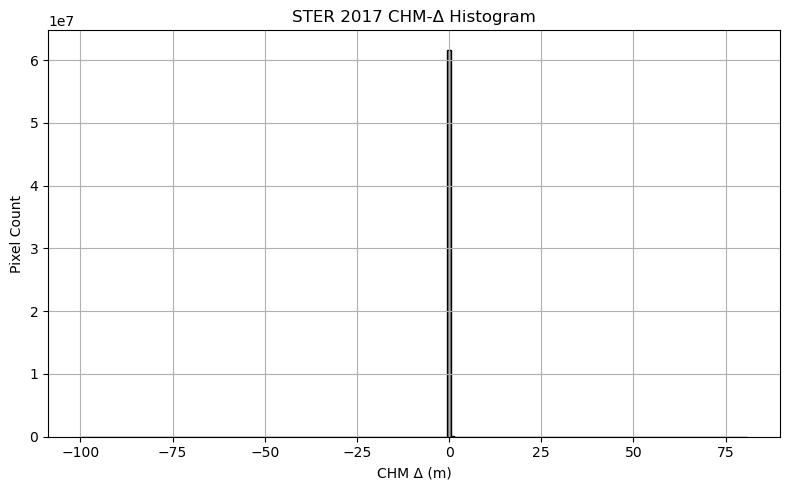

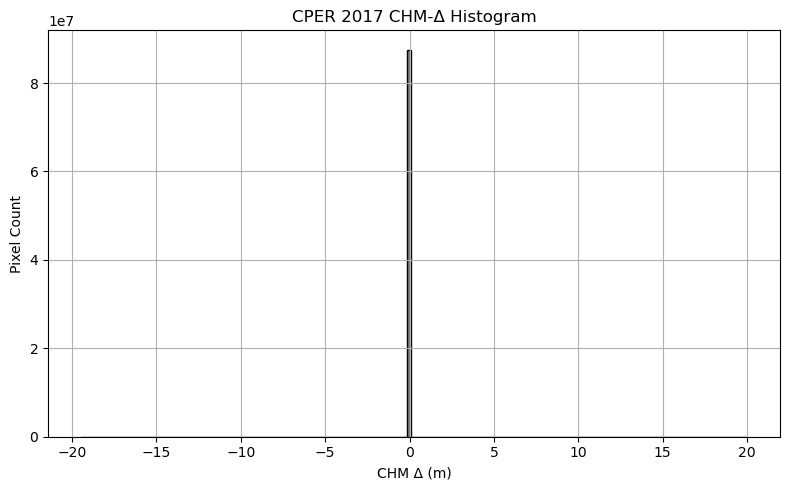

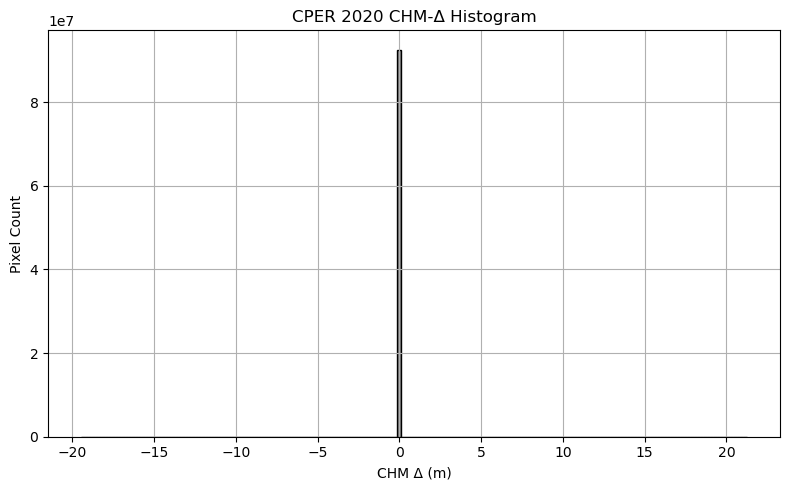

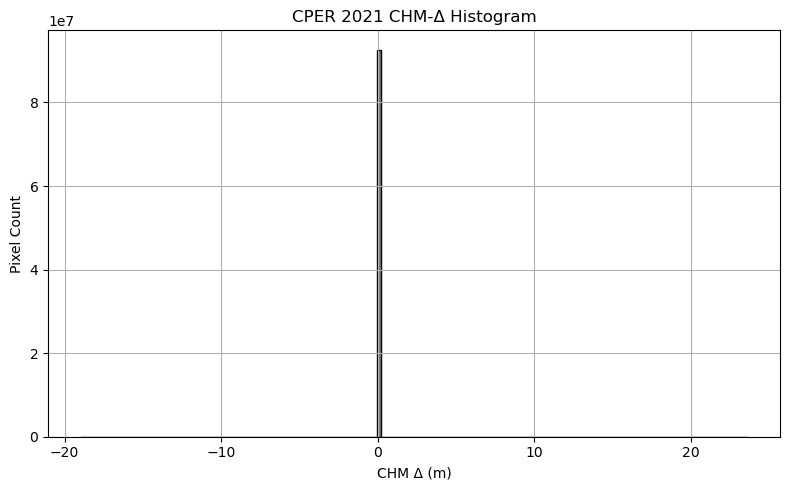

In [77]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Suspect site-years from earlier
suspect_rasters = [
    ("STER", 2017),
    ("CPER", 2017),
    ("CPER", 2020),
    ("CPER", 2021),
]

chm_root = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"

for site, year in suspect_rasters:
    chm_fp = os.path.join(chm_root, site, "differences", f"{site}_CHM_{year}_diff.tif")

    if not os.path.exists(chm_fp):
        print(f"[MISSING] {chm_fp}")
        continue

    with rasterio.open(chm_fp) as src:
        arr = src.read(1)
        nod = src.nodata if src.nodata is not None else -9999
        arr = arr[arr != nod]

    if arr.size == 0:
        print(f"[EMPTY] {site} {year}: All nodata")
        continue

    plt.figure(figsize=(8, 5))
    plt.hist(arr, bins=200, color='gray', edgecolor='black')
    plt.title(f"{site} {year} CHM-Δ Histogram")
    plt.xlabel("CHM Δ (m)")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [93]:
flat_sites = [
    ("STER", 2017),
    ("STER", 2021),
    ("STER", 2022),
    ("CPER", 2017),
    ("CPER", 2020),
    ("CPER", 2021),
    ("ARIK", 2020),
    ("ARIK", 2021),
    ("ARIK", 2023)
]

# Filter them out
df_clean = df[~df[['site', 'year']].apply(tuple, axis=1).isin(flat_sites)].copy()
print(f"Removed {len(df) - len(df_clean):,} rows from flat or broken site-years.")

Removed 1,147,778 rows from flat or broken site-years.


In [95]:
df_clean['label'] = df_clean[['chm_pct_loss', 'chm_pct_stable', 'chm_pct_gain']].idxmax(axis=1)
df_clean['label'] = df_clean['label'].map({
    'chm_pct_loss': 'Loss',
    'chm_pct_stable': 'Stable',
    'chm_pct_gain': 'Gain'
})
print(df_clean['label'].value_counts())

label
Stable    2229580
Gain         1554
Loss         1491
Name: count, dtype: int64


In [97]:
from sklearn.utils import resample

stable_df = df_clean[df_clean.label == "Stable"]
gain_df = df_clean[df_clean.label == "Gain"]
loss_df = df_clean[df_clean.label == "Loss"]

# Downsample Stable class
stable_downsampled = resample(stable_df, 
                              replace=False, 
                              n_samples=len(gain_df) + len(loss_df) * 2,
                              random_state=42)

# Combine for training
df_balanced = pd.concat([stable_downsampled, gain_df, loss_df])
print(df_balanced['label'].value_counts())

label
Stable    4536
Gain      1554
Loss      1491
Name: count, dtype: int64


### Random Forest Classification and Feature Importance Analysis

We trained a Random Forest classifier to predict canopy change categories (`Loss`, `Stable`, `Gain`) using block-level features derived from CHM-Δ rasters and vegetation indices.

#### Thresholding Strategies:
1. **Fixed Threshold (±2 m)**:
   - Initially, a static threshold of ±2 meters was used to classify change.
   - This resulted in a **severe class imbalance**, with nearly all blocks labeled as `Stable` and very few meeting the criteria for `Loss` or `Gain`.

2. **Dynamic Thresholding (1st/99th Percentiles)**:
   - To improve label diversity, we computed per-raster thresholds using the 1st and 99th percentiles of CHM-Δ values.
   - While this approach was more adaptive to site-specific variation, the resulting dataset still exhibited class imbalance, though slightly improved.

#### Steps Taken:
1. **Hybrid Resampling Strategy**:
   - The `Stable` class was downsampled to 20,000 examples, while all `Gain` and `Loss` blocks were retained to balance the dataset for training.

2. **Model Features**:
   - Features included CHM-Δ statistics (`chm_mean_diff`, `chm_std_diff`) and mean vegetation index values (`NDVI`, `EVI`, `ARVI`, `PRI`, `SAVI`).

3. **Train/Test Split**:
   - Stratified sampling was used to maintain class proportions during the train/test split.

4. **Model Training**:
   - A `RandomForestClassifier` with `class_weight='balanced'` was trained to compensate for remaining class disparities.

5. **Performance Evaluation**:
   - The classifier achieved **high accuracy (~99%)**, with strong precision, recall, and F1-scores across all classes.

#### Feature Importance:
The most informative predictors were:
- **`chm_mean_diff`**, reflecting average canopy height change.
- **`chm_std_diff`**, capturing structural variability.
- Vegetation indices added modest but meaningful contributions.

These findings support the conclusion that CHM-Δ features are highly effective at detecting forest change patterns at block scale, even when class imbalance poses challenges during labeling.

label
Stable    20000
Gain       1554
Loss       1491
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

        Gain       0.94      1.00      0.97       226
        Loss       0.98      1.00      0.99       212
      Stable       1.00      0.99      1.00      2986

    accuracy                           0.99      3424
   macro avg       0.97      0.99      0.98      3424
weighted avg       0.99      0.99      0.99      3424



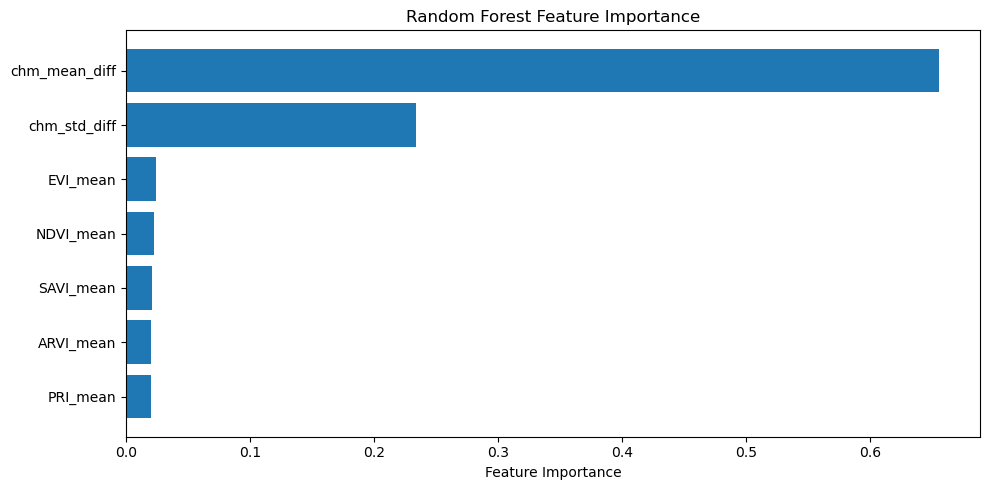

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import matplotlib.pyplot as plt

# --- 1. Resample for Hybrid Dataset ---
stable_df = df_clean[df_clean.label == "Stable"]
gain_df   = df_clean[df_clean.label == "Gain"]
loss_df   = df_clean[df_clean.label == "Loss"]

# Downsample Stable class to ~20,000
stable_sample = resample(stable_df, 
                         replace=False, 
                         n_samples=20000, 
                         random_state=42)

df_balanced = pd.concat([stable_sample, gain_df, loss_df])
print(df_balanced['label'].value_counts())

# --- 2. Define Features and Labels ---
feature_cols = ['chm_mean_diff', 'chm_std_diff'] + [f"{idx}_mean" for idx in INDICES]
X = df_balanced[feature_cols].dropna()
y = df_balanced.loc[X.index, 'label']

# --- 3. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# --- 4. Train Classifier ---
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# --- 5. Evaluate ---
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 6. Feature Importance Plot ---
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Phase 4: Expanding the Feature Set: Incorporating Topographic Context

While canopy height change metrics (`chm_mean_diff`, `chm_std_diff`) proved to be strong predictors of block-level disturbance, and vegetation indices added moderate value, there's potential to improve classification further by introducing **terrain-derived features**.

Topographic factors such as **slope** and **aspect** influence vegetation structure, water flow, and exposure to environmental stressors. These variables can provide critical context for understanding where and why canopy changes occur.

### Step 1: Download NEON Slope & Aspect Rasters (DP3.30025.001)

To further enhance our block-level feature set, we now incorporate **topographic context** using slope and aspect rasters from the NEON **Albedo, Slope, and Aspect** data product.

**Steps:**
- Query the [NEON Data Portal](https://data.neonscience.org/data-products/DP3.30025.001) for product **DP3.30025.001**.
- Download raster files ending in:
  - `_slope.tif` — pixel-wise terrain slope in degrees.
  - `_aspect.tif` — pixel-wise compass orientation of slope.
- Save these rasters into corresponding `/site/year/` folders for future sampling alongside canopy and vegetation index data.

Including slope and aspect features will help capture the influence of terrain on vegetation structure and its susceptibility to disturbance—potentially improving classification of `Loss`, `Stable`, and `Gain` blocks.

In [125]:
import os, requests, pandas as pd
from tqdm import tqdm                                

product_code = "DP3.30025.001"
site_codes   = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]
start_date   = "2013-01"
end_date     = "2023-12"
out_root     = r"D:/MSDS/MSDS 696_Practicum II/terrain_tiles"
os.makedirs(out_root, exist_ok=True)

# gather every TIFF to download
todo = []
for site in site_codes:
    q = (f"https://data.neonscience.org/api/v0/data/query?"
         f"productCode={product_code}&siteCode={site}"
         f"&startDateMonth={start_date}&endDateMonth={end_date}")
    data = requests.get(q).json().get("data", {})
    for rel in data.get("releases", []):
        for pkg in rel.get("packages", []):
            ym = pkg.get("month", "")
            if "-" not in ym:
                continue
            yr, _ = ym.split("-")
            for f in pkg.get("files", []):
                n = f["name"]
                if n.endswith(("_slope.tif", "_aspect.tif")):
                    todo.append({
                        "site": site,
                        "year": yr,
                        "name": n,
                        "url":  f["url"]
                    })

# single progress bar
for rec in tqdm(todo, desc="Downloading slope/aspect", unit="file"):
    year_dir = os.path.join(out_root, rec["site"], rec["year"])
    os.makedirs(year_dir, exist_ok=True)
    fp = os.path.join(year_dir, rec["name"])
    if not os.path.exists(fp):
        with open(fp, "wb") as fh:
            fh.write(requests.get(rec["url"]).content)

### Step 2: Mosaic Slope & Aspect Rasters by Site-Year

To prepare terrain features for block-level analysis, we mosaic all available **slope** and **aspect** raster tiles for each site and year into unified rasters. This ensures alignment with the CHM and vegetation index mosaics used in previous steps.

**Process Overview:**
- Search `terrain_tiles/` for files ending in `_slope.tif` and `_aspect.tif`.
- Group tiles by site and year, then merge them into a single raster per variable.
- Save output to `terrain_mosaics/` with consistent naming: `{site}_{year}_slope.tif` and `{site}_{year}_aspect.tif`.
- Only readable and valid GeoTIFFs are included in the mosaic.
- Outputs are compressed with LZW to reduce file size.

This preprocessing step ensures that terrain variables are spatially complete and ready for sampling at the block level.

In [128]:
from glob import glob
import os, rasterio, warnings
from rasterio.merge import merge
from tqdm import tqdm

# raw tiles and output folders
tile_root   = r"D:/MSDS/MSDS 696_Practicum II/terrain_tiles"
mosaic_root = r"D:/MSDS/MSDS 696_Practicum II/terrain_mosaics"
os.makedirs(mosaic_root, exist_ok=True)

sites = ["NIWO","WLOU","STER","RMNP","CPER","ARIK"]    # study sites
todo  = []                                             # list of (site, year, kind)

for s in sites:
    for y in sorted(os.listdir(os.path.join(tile_root, s))):
        for k in ["slope","aspect"]:
            if glob(os.path.join(tile_root, s, y, f"*_{k}.tif")):
                todo.append((s, y, k))

for site, yr, kind in tqdm(todo, desc="Mosaicking", unit="layer"):
    tifs = glob(os.path.join(tile_root, site, yr, f"*_{kind}.tif"))

    # open only readable TIFFs
    srcs = []
    for fp in tifs:
        try:
            srcs.append(rasterio.open(fp))
        except rasterio.errors.RasterioIOError:
            warnings.warn(f"Unreadable TIFF skipped: {fp}")

    if not srcs:
        continue

    mosa, tform = merge(srcs)
    profile = srcs[0].profile
    profile.update(driver="GTiff",
                   height=mosa.shape[1],
                   width=mosa.shape[2],
                   transform=tform,
                   compress="lzw")
    for s in srcs:
        s.close()

    out_dir = os.path.join(mosaic_root, site)
    os.makedirs(out_dir, exist_ok=True)
    out_fp  = os.path.join(out_dir, f"{site}_{yr}_{kind}.tif")
    with rasterio.open(out_fp, "w", **profile) as dst:
        dst.write(mosa)

Mosaicking:   2%|▏         | 1/52 [00:19<16:49, 19.79s/layer]C:\Users\macfr\AppData\Local\Temp\ipykernel_23704\1684223223.py:29: UserWarning: Unreadable TIFF skipped: D:/MSDS/MSDS 696_Practicum II/terrain_tiles\NIWO\2017\NEON_D13_NIWO_DP3_451000_4429000_aspect.tif
  warnings.warn(f"Unreadable TIFF skipped: {fp}")
C:\Users\macfr\AppData\Local\Temp\ipykernel_23704\1684223223.py:29: UserWarning: Unreadable TIFF skipped: D:/MSDS/MSDS 696_Practicum II/terrain_tiles\NIWO\2017\NEON_D13_NIWO_DP3_452000_4434000_aspect.tif
  warnings.warn(f"Unreadable TIFF skipped: {fp}")
C:\Users\macfr\AppData\Local\Temp\ipykernel_23704\1684223223.py:29: UserWarning: Unreadable TIFF skipped: D:/MSDS/MSDS 696_Practicum II/terrain_tiles\NIWO\2017\NEON_D13_NIWO_DP3_458000_4436000_aspect.tif
  warnings.warn(f"Unreadable TIFF skipped: {fp}")
Mosaicking: 100%|██████████| 52/52 [17:08<00:00, 19.77s/layer]


### Step 3: Evaluating CHM-Δ Threshold Before Incorporating Terrain Features

Before expanding our feature set to include elevation and topographic context, we assessed the impact of the CHM-Δ threshold on class balance and signal separation.

Using a histogram of pixel-wise CHM-Δ values aggregated across NEON sites, we found the distribution to be tightly centered around zero with heavy tails. This confirms that most canopy pixels exhibit little change, while a smaller subset experience substantial gain or loss.

We selected a **±1.5 m fixed threshold** for the following reasons:
- It falls just outside the core noise distribution.
- It captures the meaningful disturbance signal in the distribution tails.
- It offers better class separation than ±1.0 m (too sensitive) or ±2.0 m (too conservative).

This threshold provides a stable baseline for labeling blocks as `Loss`, `Stable`, or `Gain`—allowing us to isolate CHM-driven changes **prior** to layering in terrain context like slope, aspect, and elevation.

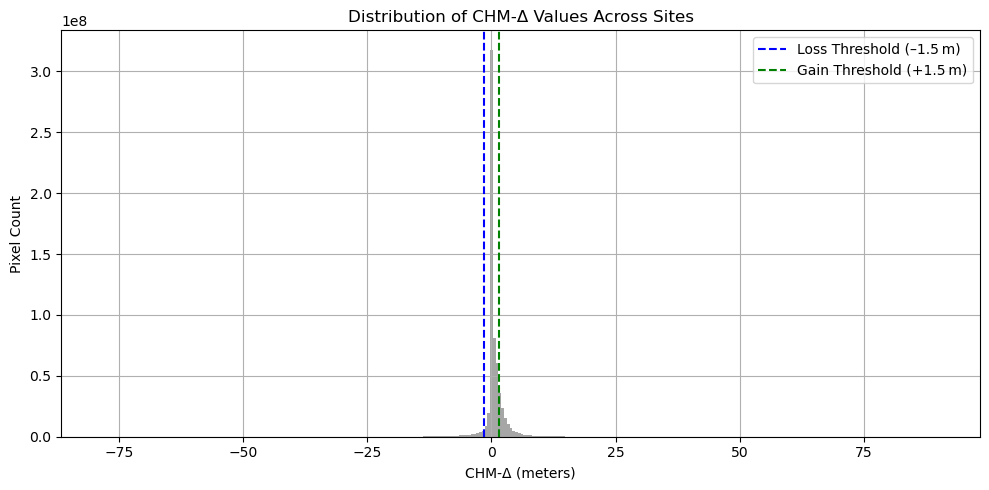

In [186]:
import matplotlib.pyplot as plt

# Load CHM-Δ values from multiple rasters (or a representative subset)
vals_all = []
for site, year, diff_fp, _ in jobs:
    with rasterio.open(diff_fp) as src:
        arr = src.read(1)
        nod = src.nodata if src.nodata is not None else -9999
        vals_all.append(arr[arr != nod])

# Flatten and stack values
vals_flat = np.concatenate(vals_all)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(vals_flat, bins=300, color="gray", alpha=0.7)
plt.axvline(-1.5, color="blue", linestyle="--", label="Loss Threshold (–1.5 m)")
plt.axvline(1.5,  color="green", linestyle="--", label="Gain Threshold (+1.5 m)")
plt.title("Distribution of CHM-Δ Values Across Sites")
plt.xlabel("CHM-Δ (meters)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Step 4: Extract Block-Level CHM, Vegetation, and Terrain Features

This step expands our block-level feature extraction by integrating **terrain context** alongside CHM-Δ and vegetation index data. For each 100×100 meter block in each NEON site-year:

- **CHM Features**:
  - `chm_pct_loss`, `chm_pct_stable`, `chm_pct_gain`: % of pixels falling below, between, or above fixed thresholds (±1.5 m).
  - `chm_delta_mean`: average canopy height change within the block.
  - `chm_mean`, `chm_std_diff`: raw height values and variability.

- **Vegetation Indices**:
  - Mean values of NDVI, EVI, ARVI, PRI, and SAVI from pre-masked rasters are sampled per block, if available.

- **Terrain Features**:
  - Mean **slope** and **aspect** values are extracted from mosaicked terrain rasters (`DP3.30025.001`) aligned with CHM data.

All valid records are stored in a unified CSV file for downstream machine learning tasks

In [191]:
import os
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm

# PARAMETERS
chm_root        = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
veg_masked_root = r"D:/MSDS/MSDS 696_Practicum II/veg_masked"
terrain_root    = r"D:/MSDS/MSDS 696_Practicum II/terrain_mosaics"
output_path     = r"D:/MSDS/MSDS 696_Practicum II/block_features_with_terrain.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

site_codes      = ["NIWO", "WLOU"]
INDICES         = ["NDVI", "EVI", "ARVI", "PRI", "SAVI"]
BLOCK_PIXELS    = 100
loss_thr, gain_thr = -1.5, 1.5  # Fixed thresholds

# Collect (site, year) paths
jobs = []
for site in site_codes:
    diff_dir = os.path.join(chm_root, site, "differences")
    if not os.path.isdir(diff_dir):
        continue
    for fn in os.listdir(diff_dir):
        if fn.endswith("_diff.tif"):
            year = int(fn.split("_")[-2])
            diff_fp = os.path.join(diff_dir, fn)

            aligned_fp = None
            aligned_dir = os.path.join(chm_root, site)
            for af in os.listdir(aligned_dir):
                if af.endswith("_aligned.tif") and str(year) in af:
                    aligned_fp = os.path.join(aligned_dir, af)
                    break

            if aligned_fp and os.path.exists(aligned_fp):
                jobs.append((site, year, diff_fp, aligned_fp))

# Loop over jobs
all_recs = []
for site, year, diff_fp, aligned_fp in tqdm(jobs, desc="Site-Year blocks"):
    try:
        with rasterio.open(diff_fp) as diff_src, rasterio.open(aligned_fp) as chm_src:
            nod = diff_src.nodata if diff_src.nodata is not None else -9999
            h, w = diff_src.height, diff_src.width

            for i in range(0, h, BLOCK_PIXELS):
                for j in range(0, w, BLOCK_PIXELS):
                    win_h = min(BLOCK_PIXELS, h - i)
                    win_w = min(BLOCK_PIXELS, w - j)
                    window = rasterio.windows.Window(j, i, win_w, win_h)

                    diff_block = diff_src.read(1, window=window)
                    chm_block  = chm_src.read(1, window=window)
                    valid = diff_block != nod
                    if valid.sum() < 0.5 * BLOCK_PIXELS**2:
                        continue

                    vals = diff_block[valid]
                    chm_vals = chm_block[valid]

                    rec = {
                        "site": site,
                        "year": year,
                        "row_off": i,
                        "col_off": j,
                        "chm_pct_loss":   (vals < loss_thr).sum() / valid.sum() * 100,
                        "chm_pct_stable": ((vals >= loss_thr) & (vals <= gain_thr)).sum() / valid.sum() * 100,
                        "chm_pct_gain":   (vals > gain_thr).sum() / valid.sum() * 100,
                        "chm_delta_mean": vals.mean(),
                        "chm_mean":       chm_vals.mean(),
                        "chm_std_diff":   vals.std()
                    }

                    # Add vegetation index means
                    for idx in INDICES:
                        vi_fp = os.path.join(veg_masked_root, site, str(year), f"{site}_{year}_{idx}_masked.tif")
                        if os.path.exists(vi_fp):
                            with rasterio.open(vi_fp) as src:
                                vb = src.read(1, window=window)
                                vn = src.nodata if src.nodata is not None else np.nan
                                mask = vb != vn
                                rec[f"{idx}_mean"] = np.nan if mask.sum() == 0 else vb[mask].mean()
                        else:
                            rec[f"{idx}_mean"] = np.nan

                    # Add terrain features (slope & aspect)
                    for kind in ["slope", "aspect"]:
                        terrain_fp = os.path.join(terrain_root, site, f"{site}_{year}_{kind}.tif")
                        if os.path.exists(terrain_fp):
                            with rasterio.open(terrain_fp) as src:
                                tb = src.read(1, window=window)
                                tn = src.nodata if src.nodata is not None else np.nan
                                mask = tb != tn
                                rec[f"{kind}_mean"] = np.nan if mask.sum() == 0 else tb[mask].mean()
                        else:
                            rec[f"{kind}_mean"] = np.nan

                    all_recs.append(rec)

    except Exception as e:
        print(f"[ERROR] {site} {year}: {e}")

# Save and report
df = pd.DataFrame(all_recs)
df.to_csv(output_path, index=False)
print(f"Saved to: {output_path} → {df.shape[0]:,} rows")

Site-Year blocks: 100%|██████████| 7/7 [59:42<00:00, 511.76s/it]  


Saved to: D:/MSDS/MSDS 696_Practicum II/block_features_with_terrain.csv → 63,390 rows


In [193]:
#read block level features
blk_df = pd.read_csv(r"D:/MSDS/MSDS 696_Practicum II/block_features_with_terrain.csv")

In [195]:
#display head
blk_df.head()

site  year  row_off  col_off  chm_pct_loss  chm_pct_stable  chm_pct_gain  \
0  NIWO  2018     2000     1800      0.376207       92.313167      7.310625   
1  NIWO  2018     2000     1900      0.011418       98.949532      1.039050   
2  NIWO  2018     2000     2000      1.155384       92.815879      6.028736   
3  NIWO  2018     2000     5800      0.024447       97.469747      2.505806   
4  NIWO  2018     2000     5900      0.091841       95.147712      4.760447   

   chm_delta_mean  chm_mean  chm_std_diff  NDVI_mean  EVI_mean  ARVI_mean  \
0        0.306409  0.346361      0.734944   0.495869  0.382491   0.405578   
1        0.086201  0.094217      0.338783   0.554438  0.446603   0.474397   
2        0.222764  0.319639      0.743138   0.446197  0.329468   0.356688   
3        0.085094  0.093029      0.384502   0.538399  0.363394   0.414015   
4        0.182077  0.210872      0.542181   0.598485  0.461750   0.489171   

   PRI_mean  SAVI_mean  slope_mean  aspect_mean  
0 -0.053838   0.343965   32.801651   118.943062  
1 -0.053262   0.395738   21.357859   132.547119  
2 -0.051458   0.296352   11.818133   171.017822  
3 -0.070519   0.349558    8.881423   231.553802  
4 -0.071886   0.428641    7.604396   311.399902

In [204]:
#display info
blk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63390 entries, 0 to 63389
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site            63390 non-null  object 
 1   year            63390 non-null  int64  
 2   row_off         63390 non-null  int64  
 3   col_off         63390 non-null  int64  
 4   chm_pct_loss    63390 non-null  float64
 5   chm_pct_stable  63390 non-null  float64
 6   chm_pct_gain    63390 non-null  float64
 7   chm_delta_mean  63390 non-null  float64
 8   chm_mean        63390 non-null  float64
 9   chm_std_diff    63390 non-null  float64
 10  NDVI_mean       46497 non-null  float64
 11  EVI_mean        46497 non-null  float64
 12  ARVI_mean       46497 non-null  float64
 13  PRI_mean        46497 non-null  float64
 14  SAVI_mean       46497 non-null  float64
 15  slope_mean      50651 non-null  float64
 16  aspect_mean     50651 non-null  float64
dtypes: float64(13), int64(3), objec

## Phase 5: Hybrid Resampling and Model Training

We define the dominant canopy change category for each block by selecting the class with the highest percentage among `chm_pct_loss`, `chm_pct_stable`, and `chm_pct_gain`. This becomes the block’s `label` and serves as the target variable for machine learning classification.

This step also helps reveal class imbalance, which may inform later resampling or threshold adjustment decisions.

In [207]:
blk_df['label'] = blk_df[['chm_pct_loss', 'chm_pct_stable', 'chm_pct_gain']].idxmax(axis=1)
blk_df['label'] = blk_df['label'].str.replace('chm_pct_', '').str.capitalize()
print(blk_df['label'].value_counts(normalize=True) * 100)

label
Stable    97.688910
Gain       2.161224
Loss       0.149866
Name: proportion, dtype: float64


### Step 1 – Assigning Dominant Change Class (`label`)

We assign each block a dominant canopy change class (`Loss`, `Stable`, or `Gain`) by selecting the category with the highest percentage of pixels within the block. This is derived from the `chm_pct_loss`, `chm_pct_stable`, and `chm_pct_gain` columns and stored in a new column called `label`.

#### Observed Class Distribution:
- **Stable**: 97.7%
- **Gain**: 2.2%
- **Loss**: 0.15%

This significant class imbalance—dominated by `Stable` blocks—suggests a need for resampling or rebalancing techniques prior to training any predictive models.


### Step 2 – Downsampling for Class Balance

To address the class imbalance, we apply a downsampling strategy:

- **Stable** blocks are randomly downsampled to reduce their dominance.
- All `Gain` and `Loss` examples are retained.
- This approach preserves minority class information while creating a more balanced dataset for modeling.

The resulting balanced dataset will provide a stronger foundation for training classification models without overwhelming the learning process with the majority `Stable` class.

In [211]:
from sklearn.utils import resample

# Split the dataset by class
stable_df = blk_df[blk_df["label"] == "Stable"]
gain_df   = blk_df[blk_df["label"] == "Gain"]
loss_df   = blk_df[blk_df["label"] == "Loss"]

# Downsample the Stable class to match the total of Gain and Loss
stable_down = resample(
    stable_df,
    replace=False,
    n_samples=len(gain_df) + len(loss_df) * 2,  # adjust ratio as needed
    random_state=42
)

# Combine into a balanced DataFrame
df_balanced = pd.concat([stable_down, gain_df, loss_df], ignore_index=True)

# Check new class distribution
print(df_balanced["label"].value_counts(normalize=True) * 100)

label
Stable    51.570248
Gain      45.289256
Loss       3.140496
Name: proportion, dtype: float64


### Step 4 – Prepare Features and Labels for Model Training

We defined our feature set by combining CHM-derived statistics (mean, std, delta), vegetation indices (NDVI, EVI, etc.), and terrain features (slope and aspect). Rows with missing values in any feature or label were dropped to ensure clean input for modeling.


In [217]:
# Define model input features
feature_cols = [
    "chm_delta_mean", "chm_mean", "chm_std_diff",
    "slope_mean", "aspect_mean",
    "NDVI_mean", "EVI_mean", "ARVI_mean", "PRI_mean", "SAVI_mean"
]

# Drop rows with missing data
df_clean = df_balanced.dropna(subset=feature_cols + ["label"])

# Define features (X) and labels (y)
X = df_clean[feature_cols]
y = df_clean["label"]

# Confirm shape
print("Feature shape:", X.shape)
print("Class distribution:\n", y.value_counts(normalize=True) * 100)

Feature shape: (1335, 10)
Class distribution:
 label
Stable    64.868914
Gain      32.808989
Loss       2.322097
Name: proportion, dtype: float64


### Step 5 – Train/Test Split

We split the cleaned, balanced dataset into training and testing sets using stratified sampling to preserve class proportions. This ensures fair evaluation of model performance across all canopy change categories (`Loss`, `Stable`, `Gain`).

In [220]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (stratified by class)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (934, 10)
Test set size: (401, 10)


### Step 6 – Train the Random Forest Classifier

We train a `RandomForestClassifier` using the balanced training dataset. The model uses the selected block-level features—including CHM change metrics, vegetation indices, and terrain attributes—to classify blocks into `Loss`, `Stable`, or `Gain` categories.

We also set `class_weight='balanced'` to ensure the model accounts for any residual imbalance during training.


In [224]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

print("✅ Model training complete")

✅ Model training complete


### Step 7 – Evaluate Model Performance & Interpret Feature Importance

After training the Random Forest classifier, we evaluate its performance on the test set using precision, recall, F1-score, and overall accuracy.

We also examine feature importances to understand which block-level variables contribute most to predicting canopy change classes. This can offer insight into the relative influence of vegetation structure, spectral indices, and terrain context.


📊 Classification Report:

              precision    recall  f1-score   support

        Gain       0.96      0.98      0.97       132
        Loss       1.00      1.00      1.00         9
      Stable       0.99      0.98      0.99       260

    accuracy                           0.98       401
   macro avg       0.99      0.99      0.99       401
weighted avg       0.98      0.98      0.98       401



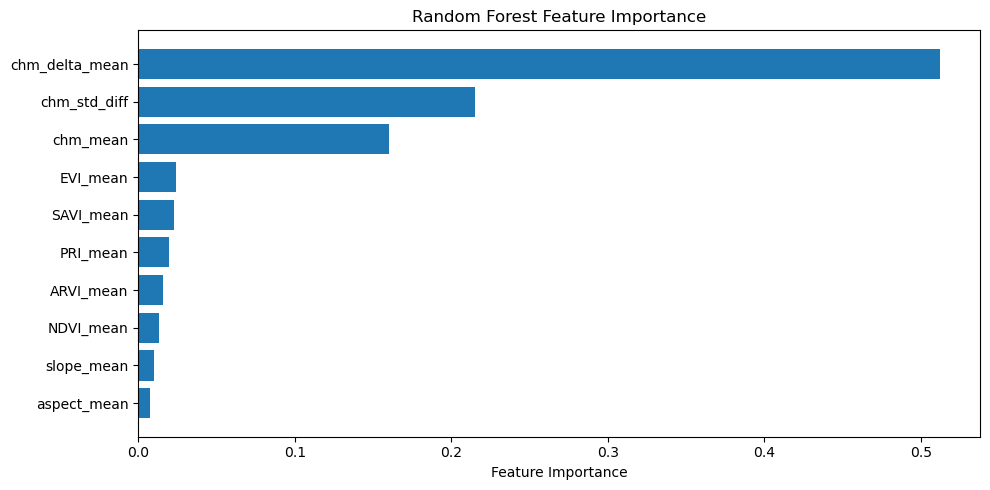

In [227]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred = clf.predict(X_test)

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Feature importance
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_cols[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_features)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Step 7 – Model Evaluation & Feature Interpretation

We evaluated the Random Forest classifier on the test set using key metrics:

- **Accuracy:** 98%
- **Precision & Recall:** High for all classes, including rare `Loss` events
- **F1-Score:** Ranges from 0.97–1.00, showing excellent balance and performance

#### Feature Importance Insights:
The plot reveals that CHM-based features are by far the most predictive:

- **`chm_delta_mean`** was the strongest contributor, reflecting its central role in detecting canopy change.
- **`chm_std_diff`** and **`chm_mean`** also showed substantial importance, indicating structural variation is key.
- Vegetation indices (e.g., NDVI, EVI, SAVI) added some signal but were secondary.
- Terrain variables (`slope_mean`, `aspect_mean`) showed minimal contribution in this model.

These results suggest that block-scale structural change is the dominant indicator of canopy dynamics, though additional features may become more useful in larger or more heterogeneous datasets.

## Phase 6: Model Reassessment and Feature Integrity Check

### Step 1: Validate Spatial Alignment of Terrain Data

Before reusing terrain-based features (e.g., slope, aspect), we verify that the resampled terrain rasters are properly aligned with the CHM rasters used for canopy analysis. This includes checking:

- CRS (Coordinate Reference System) consistency  
- Matching raster dimensions (height, width)  
- Affine transform agreement (origin, pixel size, orientation)

Any mismatch would indicate misalignment, which could compromise feature reliability and model validity. Proper alignment is crucial for ensuring that terrain statistics are calculated from the same spatial footprint as the canopy change data.

In [262]:
import rasterio

# Example file paths for NIWO 2017 — adjust site/year as needed
chm_fp     = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics/NIWO/NIWO_CHM_2017_aligned.tif"
slope_fp   = r"D:/MSDS/MSDS 696_Practicum II/terrain_mosaics/NIWO/NIWO_2017_slope.tif"
aspect_fp  = r"D:/MSDS/MSDS 696_Practicum II/terrain_mosaics/NIWO/NIWO_2017_aspect.tif"

def compare_rasters(fp1, fp2):
    with rasterio.open(fp1) as r1, rasterio.open(fp2) as r2:
        print(f"\nComparing:\n→ {os.path.basename(fp1)}\n→ {os.path.basename(fp2)}")
        print(f"CRS Match:       {r1.crs == r2.crs}")
        print(f"Shape Match:     {r1.shape == r2.shape}")
        print(f"Transform Match: {r1.transform == r2.transform}")
        print(f"\nCHM Grid:\n  {r1.shape} | {r1.transform}")
        print(f"Terrain Grid:\n  {r2.shape} | {r2.transform}")

compare_rasters(chm_fp, slope_fp)
compare_rasters(chm_fp, aspect_fp)


Comparing:
→ NIWO_CHM_2017_aligned.tif
→ NIWO_2017_slope.tif
CRS Match:       True
Shape Match:     False
Transform Match: False

CHM Grid:
  (17000, 16000) | | 1.00, 0.00, 443000.00|
| 0.00,-1.00, 4439000.00|
| 0.00, 0.00, 1.00|
Terrain Grid:
  (15644, 14953) | | 1.00, 0.00, 443721.00|
| 0.00,-1.00, 4438611.00|
| 0.00, 0.00, 1.00|

Comparing:
→ NIWO_CHM_2017_aligned.tif
→ NIWO_2017_aspect.tif
CRS Match:       True
Shape Match:     False
Transform Match: False

CHM Grid:
  (17000, 16000) | | 1.00, 0.00, 443000.00|
| 0.00,-1.00, 4439000.00|
| 0.00, 0.00, 1.00|
Terrain Grid:
  (15644, 14953) | | 1.00, 0.00, 443721.00|
| 0.00,-1.00, 4438611.00|
| 0.00, 0.00, 1.00|


### Step 2: Identifying and Correcting Terrain Misalignment

After training the initial model, I reviewed the alignment of input rasters and discovered that the terrain layers (slope and aspect) were not spatially aligned with the CHM data. Although the CRS (coordinate reference systems) matched, the raster dimensions and geotransforms were misaligned. This mismatch meant that terrain features were being extracted from different spatial locations than the CHM and vegetation index values—potentially weakening the model's reliability.

To fix this, I implemented a resampling step that aligned all slope and aspect rasters to the corresponding CHM grid using bilinear interpolation. This ensured that every 100×100 block used for feature extraction sampled from the same geographic footprint across all layers. The resampled terrain rasters were saved with a `_resampled.tif` suffix and used in subsequent feature extraction runs.

In [252]:
import os
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
from tqdm import tqdm

# INPUT PATHS
chm_root = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
terrain_root = r"D:/MSDS/MSDS 696_Practicum II/terrain_mosaics"
kinds = ["slope", "aspect"]

# Loop through each site
for site in os.listdir(terrain_root):
    site_dir = os.path.join(terrain_root, site)
    if not os.path.isdir(site_dir):
        continue

    # Loop through each year for this site based on terrain files
    for fname in os.listdir(site_dir):
        if not any(fname.endswith(f"{kind}.tif") for kind in kinds):
            continue

        # Extract year and kind
        parts = fname.split("_")
        if len(parts) < 3:
            continue  # unexpected filename format

        year = parts[1]
        kind = parts[2].split(".")[0]  # remove .tif

        # Paths
        terrain_fp = os.path.join(site_dir, fname)
        chm_fp = os.path.join(chm_root, site, f"{site}_CHM_{year}_aligned.tif")
        dst_fp = os.path.join(site_dir, f"{site}_{year}_{kind}_resampled.tif")

        if not os.path.exists(chm_fp):
            print(f"⚠️  Missing CHM: {chm_fp}")
            continue

        try:
            # Open reference CHM raster
            with rasterio.open(chm_fp) as ref:
                ref_profile = ref.profile
                dst_shape = (ref.height, ref.width)
                dst_transform = ref.transform
                dst_crs = ref.crs

            # Open terrain raster
            with rasterio.open(terrain_fp) as src:
                src_data = src.read(1)
                src_nodata = src.nodata
                dst_data = np.empty(dst_shape, dtype=src_data.dtype)

                reproject(
                    source=src_data,
                    destination=dst_data,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.bilinear
                )

                profile = ref_profile.copy()
                profile.update({
                    "dtype": dst_data.dtype,
                    "nodata": src_nodata,
                    "height": dst_shape[0],
                    "width": dst_shape[1],
                    "transform": dst_transform,
                    "compress": "lzw"
                })

                with rasterio.open(dst_fp, "w", **profile) as dst:
                    dst.write(dst_data, 1)

            print(f"✅ Resampled: {dst_fp}")

        except Exception as e:
            print(f"❌ Failed on {terrain_fp}: {e}")

✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2017_aspect_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2017_slope_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2020_aspect_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2020_slope_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2021_aspect_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2021_slope_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2023_aspect_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\ARIK\ARIK_2023_slope_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\CPER\CPER_2013_aspect_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosaics\CPER\CPER_2013_slope_resampled.tif
✅ Resampled: D:/MSDS/MSDS 696_Practicum II/terrain_mosa

### Step 3: Verifying Alignment of Resampled Terrain Rasters

After resampling the terrain layers to match the CHM rasters, I ran a verification check to confirm alignment. This script iterates through each site and year, comparing the raster shape, transform, and coordinate reference system (CRS) between the CHM and the corresponding resampled slope and aspect rasters. A status message is printed to indicate whether each terrain layer is correctly aligned with its CHM counterpart. Ensuring precise alignment is critical for reliable block-level feature extraction in later modeling steps.


In [266]:
import os
import rasterio

chm_root = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
terrain_root = r"D:/MSDS/MSDS 696_Practicum II/terrain_mosaics"
kinds = ["slope", "aspect"]

# Loop through all site folders in terrain_root
for site in os.listdir(terrain_root):
    site_path = os.path.join(terrain_root, site)
    if not os.path.isdir(site_path):
        continue

    # Find all CHM aligned files for this site
    chm_dir = os.path.join(chm_root, site)
    if not os.path.isdir(chm_dir):
        continue

    chm_files = [f for f in os.listdir(chm_dir) if "_CHM_" in f and f.endswith("_aligned.tif")]

    for chm_file in chm_files:
        year = chm_file.split("_")[2]
        chm_fp = os.path.join(chm_dir, chm_file)

        with rasterio.open(chm_fp) as chm:
            chm_shape = (chm.height, chm.width)
            chm_transform = chm.transform
            chm_crs = chm.crs

        for kind in kinds:
            terrain_fp = os.path.join(terrain_root, site, f"{site}_{year}_{kind}_resampled.tif")
            if not os.path.exists(terrain_fp):
                print(f"❌ MISSING: {site} {year} {kind}")
                continue

            with rasterio.open(terrain_fp) as terr:
                aligned = (
                    terr.shape == chm_shape and
                    terr.transform == chm_transform and
                    terr.crs == chm_crs
                )
                status = "✅ ALIGNED" if aligned else "❌ MISMATCH"
                print(f"{site} {year} {kind}: {status}")

ARIK 2017 slope: ✅ ALIGNED
ARIK 2017 aspect: ✅ ALIGNED
ARIK 2020 slope: ✅ ALIGNED
ARIK 2020 aspect: ✅ ALIGNED
ARIK 2021 slope: ✅ ALIGNED
ARIK 2021 aspect: ✅ ALIGNED
ARIK 2023 slope: ✅ ALIGNED
ARIK 2023 aspect: ✅ ALIGNED
CPER 2013 slope: ✅ ALIGNED
CPER 2013 aspect: ✅ ALIGNED
CPER 2017 slope: ✅ ALIGNED
CPER 2017 aspect: ✅ ALIGNED
CPER 2020 slope: ✅ ALIGNED
CPER 2020 aspect: ✅ ALIGNED
CPER 2021 slope: ✅ ALIGNED
CPER 2021 aspect: ✅ ALIGNED
NIWO 2017 slope: ✅ ALIGNED
NIWO 2017 aspect: ✅ ALIGNED
NIWO 2018 slope: ✅ ALIGNED
NIWO 2018 aspect: ✅ ALIGNED
NIWO 2019 slope: ✅ ALIGNED
NIWO 2019 aspect: ✅ ALIGNED
NIWO 2020 slope: ✅ ALIGNED
NIWO 2020 aspect: ✅ ALIGNED
NIWO 2023 slope: ✅ ALIGNED
NIWO 2023 aspect: ✅ ALIGNED
RMNP 2017 slope: ✅ ALIGNED
RMNP 2017 aspect: ✅ ALIGNED
RMNP 2018 slope: ✅ ALIGNED
RMNP 2018 aspect: ✅ ALIGNED
RMNP 2020 slope: ✅ ALIGNED
RMNP 2020 aspect: ✅ ALIGNED
RMNP 2022 slope: ✅ ALIGNED
RMNP 2022 aspect: ✅ ALIGNED
RMNP 2023 slope: ✅ ALIGNED
RMNP 2023 aspect: ✅ ALIGNED
STER 2013 

### Step 4: Block-Level Feature Extraction and Feature Redesign

In this step, we rebuilt our block-level dataset using only aligned terrain data and valid CHM windows, expanding the set of structural features. Instead of relying on `chm_mean_diff`, which was highly correlated with our target (gain/loss/stable) and thus introduced label leakage, we shifted to purely descriptive CHM features: mean, median, standard deviation, min, max, 95th percentile, and interquartile range. These metrics offer richer, unbiased insights into canopy structure. We also re-integrated vegetation index means and aligned slope/aspect data to construct a more robust feature set.

Each row in the output dataset corresponds to a 100×100 pixel block extracted from CHM mosaics. Since these mosaics are in 1-meter resolution, each block represents a 100m × 100m (1-hectare) patch of forest canopy. Canopy change labels (Gain/Loss/Stable) are assigned based on the proportion of pixels within each block that exceed a ±1.5 meter threshold. The final dataset, `block_features_final.csv`, provides a high-resolution, spatially explicit input for subsequent modeling workflows.


In [ ]:
#### import os
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm

# --- PARAMETERS ---
chm_root        = r"C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/aligned_mosaics"
veg_masked_root = r"D:/MSDS/MSDS 696_Practicum II/veg_masked"
terrain_root    = r"D:/MSDS/MSDS 696_Practicum II/terrain_mosaics"
output_path     = r"D:/MSDS/MSDS 696_Practicum II/block_features_final.csv"

site_codes = ["NIWO", "WLOU", "STER", "RMNP", "CPER", "ARIK"]
INDICES    = ["NDVI", "EVI", "ARVI", "PRI", "SAVI"]
BLOCK_PIXELS = 100
loss_thr, gain_thr = -1.5, 1.5

os.makedirs(os.path.dirname(output_path), exist_ok=True)

# --- Collect jobs ---
jobs = []
for site in site_codes:
    diff_dir = os.path.join(chm_root, site, "differences")
    if not os.path.isdir(diff_dir):
        continue
    for fn in os.listdir(diff_dir):
        if fn.endswith("_diff.tif"):
            year = int(fn.split("_")[-2])
            diff_fp = os.path.join(diff_dir, fn)
            aligned_fp = next((
                os.path.join(chm_root, site, af)
                for af in os.listdir(os.path.join(chm_root, site))
                if af.endswith("_aligned.tif") and str(year) in af
            ), None)
            if aligned_fp and os.path.exists(aligned_fp):
                jobs.append((site, year, diff_fp, aligned_fp))

# --- Process blocks ---
all_recs = []
for site, year, diff_fp, aligned_fp in tqdm(jobs, desc="Site-Year jobs"):
    try:
        with rasterio.open(diff_fp) as diff_src, rasterio.open(aligned_fp) as chm_src:
            nod = diff_src.nodata if diff_src.nodata is not None else -9999
            h, w = diff_src.height, diff_src.width

            for i in range(0, h, BLOCK_PIXELS):
                for j in range(0, w, BLOCK_PIXELS):
                    win_h = min(BLOCK_PIXELS, h - i)
                    win_w = min(BLOCK_PIXELS, w - j)
                    window = rasterio.windows.Window(j, i, win_w, win_h)

                    diff_block = diff_src.read(1, window=window)
                    chm_block  = chm_src.read(1, window=window)
                    valid = diff_block != nod
                    if valid.sum() < 0.5 * BLOCK_PIXELS**2:
                        continue

                    vals = diff_block[valid]
                    chm_vals = chm_block[valid]

                    rec = {
                        "site": site,
                        "year": year,
                        "row_off": i,
                        "col_off": j,
                        "chm_pct_loss":   (vals < loss_thr).sum() / valid.sum() * 100,
                        "chm_pct_stable": ((vals >= loss_thr) & (vals <= gain_thr)).sum() / valid.sum() * 100,
                        "chm_pct_gain":   (vals > gain_thr).sum() / valid.sum() * 100,
                        "chm_mean":       chm_vals.mean(),
                        "chm_std":        chm_vals.std(),
                        "chm_min":        chm_vals.min(),
                        "chm_max":        chm_vals.max(),
                        "chm_p95":        np.percentile(chm_vals, 95),
                        "chm_median":     np.median(chm_vals),
                        "chm_iqr":        np.percentile(chm_vals, 75) - np.percentile(chm_vals, 25)
                    }

                    # --- Vegetation Indices ---
                    for idx in INDICES:
                        vi_fp = os.path.join(veg_masked_root, site, str(year), f"{site}_{year}_{idx}_masked.tif")
                        if os.path.exists(vi_fp):
                            with rasterio.open(vi_fp) as src:
                                vb = src.read(1, window=window)
                                vn = src.nodata if src.nodata is not None else np.nan
                                mask = vb != vn
                                rec[f"{idx}_mean"] = np.nan if mask.sum() == 0 else vb[mask].mean()
                        else:
                            rec[f"{idx}_mean"] = np.nan

                    # --- Terrain Features ---
                    for kind in ["slope", "aspect"]:
                        tname = f"{site}_{year}_{kind}_resampled.tif"
                        tfp = os.path.join(terrain_root, site, tname)
                        if os.path.exists(tfp):
                            with rasterio.open(tfp) as src:
                                tb = src.read(1, window=window)
                                tn = src.nodata if src.nodata is not None else np.nan
                                mask = tb != tn
                                rec[f"{kind}_mean"] = np.nan if mask.sum() == 0 else tb[mask].mean()
                        else:
                            rec[f"{kind}_mean"] = np.nan

                    all_recs.append(rec)

    except Exception as e:
        print(f"[ERROR] {site} {year}: {e}")

# --- Save to CSV ---
df = pd.DataFrame(all_recs)
df.to_csv(output_path, index=False)
print(f"✅ Saved to: {output_path} → {df.shape[0]:,} rows")

In [ ]:
# Load data
df = pd.read_csv("D:/MSDS/MSDS 696_Practicum II/block_features_final.csv")

In [64]:
df.head()

site  year  row_off  col_off  chm_pct_loss  chm_pct_stable  chm_pct_gain  \
0  NIWO  2018     2000     1800      0.376207       92.313167      7.310625   
1  NIWO  2018     2000     1900      0.011418       98.949532      1.039050   
2  NIWO  2018     2000     2000      1.155384       92.815879      6.028736   
3  NIWO  2018     2000     5800      0.024447       97.469747      2.505806   
4  NIWO  2018     2000     5900      0.091841       95.147712      4.760447   

   chm_mean   chm_std  chm_min  ...  chm_p95  chm_median  chm_iqr  NDVI_mean  \
0  0.346361  0.760520      0.0  ...   1.8660         0.0      0.0   0.495869   
1  0.094217  0.387438      0.0  ...   0.8890         0.0      0.0   0.554438   
2  0.319639  0.758525      0.0  ...   1.8455         0.0      0.0   0.446197   
3  0.093029  0.403077      0.0  ...   0.9270         0.0      0.0   0.538399   
4  0.210872  0.596988      0.0  ...   1.5604         0.0      0.0   0.598485   

   EVI_mean  ARVI_mean  PRI_mean  SAVI_mean  slope_mean  aspect_mean  
0  0.382491   0.405578 -0.053838   0.343965         NaN          NaN  
1  0.446603   0.474397 -0.053262   0.395738         NaN          NaN  
2  0.329468   0.356688 -0.051458   0.296352         NaN          NaN  
3  0.363394   0.414015 -0.070519   0.349558         NaN          NaN  
4  0.461750   0.489171 -0.071886   0.428641         NaN          NaN  

[5 rows x 21 columns]

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244674 entries, 0 to 244673
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   site            244674 non-null  object 
 1   year            244674 non-null  int64  
 2   row_off         244674 non-null  int64  
 3   col_off         244674 non-null  int64  
 4   chm_pct_loss    244674 non-null  float64
 5   chm_pct_stable  244674 non-null  float64
 6   chm_pct_gain    244674 non-null  float64
 7   chm_mean        244674 non-null  float32
 8   chm_std         244674 non-null  float32
 9   chm_min         244674 non-null  float32
 10  chm_max         244674 non-null  float32
 11  chm_p95         244674 non-null  float64
 12  chm_median      244674 non-null  float32
 13  chm_iqr         244674 non-null  float64
 14  NDVI_mean       128381 non-null  float64
 15  EVI_mean        128381 non-null  float64
 16  ARVI_mean       128381 non-null  float64
 17  PRI_mean  

### Step 5: Sensitivity Analysis – CHM Labeling Thresholds

To ensure our label assignment (Gain, Loss, Stable) meaningfully captures block-level canopy change while minimizing noise, we conducted a sensitivity test across thresholds of 2%, 5%, 10%, 15%, and 20%. For each threshold, we labeled blocks based on whether more than that percentage of pixels experienced CHM gain (> +1.5m) or loss (< -1.5m).

This test helps evaluate trade-offs between label noise, ecological relevance, and class balance for modeling. A threshold of **10%** provides a strong balance—filtering out minor jitter while retaining meaningful forest dynamics.

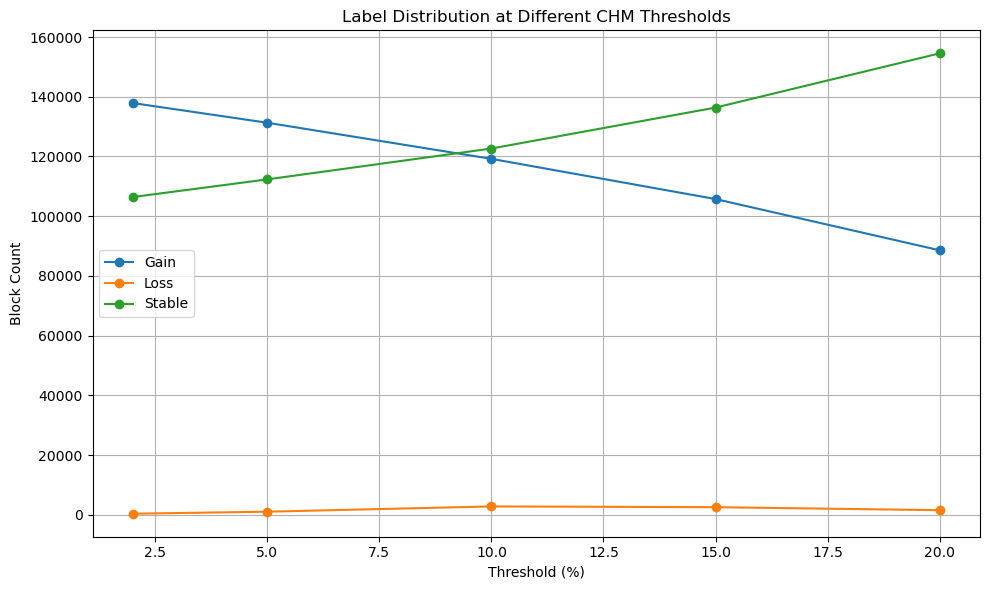

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("D:/MSDS/MSDS 696_Practicum II/block_features_final.csv")

# Thresholds to test (in percent)
thresholds = [2, 5, 10, 15, 20]
results = []

# Apply each threshold and record class distribution
for thr in thresholds:
    def label_change(row):
        if row['chm_pct_gain'] > thr:
            return 'Gain'
        elif row['chm_pct_loss'] > thr:
            return 'Loss'
        else:
            return 'Stable'
    
    labels = df.apply(label_change, axis=1)
    counts = labels.value_counts()
    for label in ['Gain', 'Loss', 'Stable']:
        results.append({
            'threshold': thr,
            'label': label,
            'count': counts.get(label, 0)
        })

# Convert results to DataFrame
plot_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
for label in ['Gain', 'Loss', 'Stable']:
    subset = plot_df[plot_df['label'] == label]
    plt.plot(subset['threshold'], subset['count'], label=label, marker='o')

plt.title('Label Distribution at Different CHM Thresholds')
plt.xlabel('Threshold (%)')
plt.ylabel('Block Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 6: Terrain-Only Random Forest Model with Imputation

We trained a baseline Random Forest classifier using only terrain-derived features: `slope_mean` and `aspect_mean`. This helped assess the predictive power of topographic structure alone in distinguishing between canopy gain, loss, and stability.

To ensure no data was excluded due to missing terrain values, we applied mean imputation to `slope_mean` and `aspect_mean`, allowing us to retain the full dataset for modeling. 

Labels were assigned using a 10% threshold for `chm_pct_gain` and `chm_pct_loss`. This value was chosen based on sensitivity testing, which showed that 10% yielded a more balanced distribution of gain, loss, and stable classes—while still focusing on substantial canopy change. The model was evaluated using a stratified train-test split and a classification report.

Classification Report:

              precision    recall  f1-score   support

        Gain       0.84      0.90      0.87     29801
        Loss       0.06      0.06      0.06       702
      Stable       0.91      0.85      0.88     30666

    accuracy                           0.86     61169
   macro avg       0.60      0.60      0.60     61169
weighted avg       0.87      0.86      0.86     61169



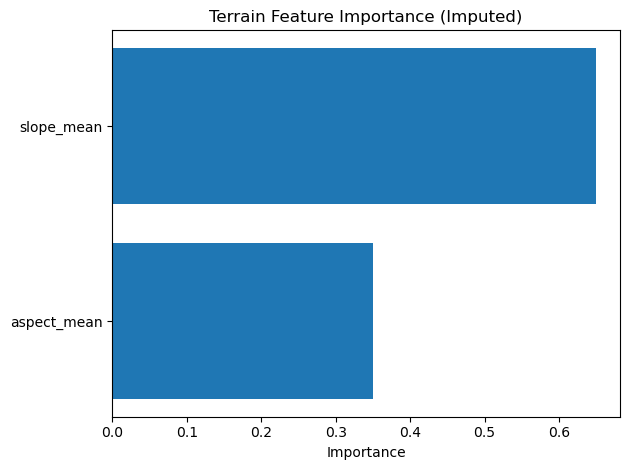

In [122]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# --- Load Data ---
df = pd.read_csv("D:/MSDS/MSDS 696_Practicum II/block_features_final.csv")

# --- Label Based on CHM Thresholds (10%) ---
def label_change(row):
    if row['chm_pct_gain'] > 10:
        return 'Gain'
    elif row['chm_pct_loss'] > 10:
        return 'Loss'
    else:
        return 'Stable'

df['label'] = df.apply(label_change, axis=1)

# --- Impute Missing Terrain Values ---
terrain_features = ['slope_mean', 'aspect_mean']
X = df[terrain_features]
y = df['label']

# Impute using column means
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=terrain_features)

# Remove any remaining missing labels (shouldn't happen, but safe)
valid_idx = y.notna()
X_final = X_imputed.loc[valid_idx]
y_final = y.loc[valid_idx]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, stratify=y_final, random_state=42
)

# --- Train Classifier ---
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# --- Evaluate Model ---
y_pred = clf.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# --- Feature Importance Plot ---
importances = clf.feature_importances_
plt.barh(terrain_features, importances)
plt.xlabel("Importance")
plt.title("Terrain Feature Importance (Imputed)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Terrain-Only Random Forest Model (with Imputation)

To evaluate the predictive power of topographic structure alone, we trained a baseline Random Forest classifier using only `slope_mean` and `aspect_mean`. Missing terrain values were imputed using the mean for each column, ensuring a complete dataset for training.

Labels were assigned using a 10% threshold for `chm_pct_gain` and `chm_pct_loss`, selected through sensitivity testing for balanced class representation.

**Key Results:**
- **Accuracy**: 86%
- **Gain**: F1 = 0.87 (High precision and recall)
- **Stable**: F1 = 0.88 (Strong classification performance)
- **Loss**: F1 = 0.06 (Performance remains limited due to class imbalance and weaker terrain signal)

**Feature Importance**:
- `slope_mean` had higher predictive value than `aspect_mean`, which aligns with ecological reasoning—slope may influence canopy growth via water runoff, snowpack retention, or disturbance likelihood.

This model serves as a baseline before incorporating structural and vegetation-based features into a more comprehensive classification pipeline.

### Step 7: Full Feature Random Forest Model

This step integrates all available predictors—CHM-derived structural metrics, vegetation index means, and terrain features—to train a comprehensive Random Forest classifier. Missing values in vegetation and terrain inputs were imputed using column means.

We retained the 10% gain/loss labeling threshold for consistency and model comparability. After a stratified train/test split, the model was trained with class balancing to account for underrepresented loss events.

**Goals:**
- Assess the combined predictive power of structural, vegetation, and terrain features
- Compare performance against the terrain-only baseline

**Outputs:**
- Full classification report with precision, recall, and F1-scores per class
- A ranked feature importance chart, indicating which variables contribute most to distinguishing canopy change types

Classification Report:

              precision    recall  f1-score   support

        Gain       0.94      0.99      0.97     29801
        Loss       0.67      0.14      0.24       702
      Stable       0.99      0.96      0.97     30666

    accuracy                           0.96     61169
   macro avg       0.87      0.70      0.73     61169
weighted avg       0.96      0.96      0.96     61169



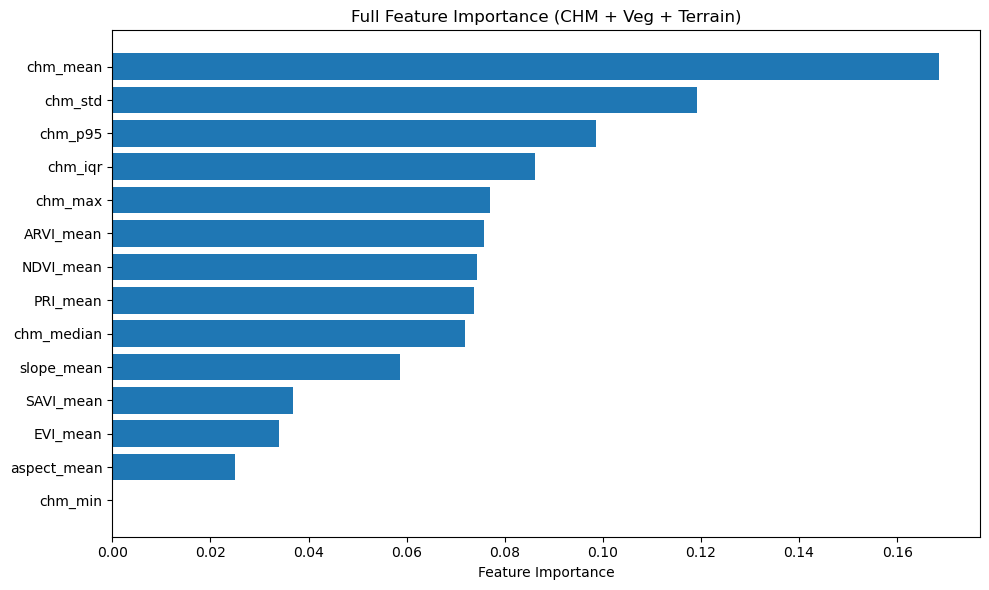

In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# --- Load and Label Data ---
df = pd.read_csv("D:/MSDS/MSDS 696_Practicum II/block_features_final.csv")
df['label'] = df.apply(lambda row: (
    'Gain' if row['chm_pct_gain'] > 10 else
    'Loss' if row['chm_pct_loss'] > 10 else
    'Stable'
), axis=1)

# --- Impute missing vegetation/terrain with column means ---
feature_cols = [
    'chm_mean', 'chm_std', 'chm_min', 'chm_max', 'chm_p95', 'chm_median', 'chm_iqr',
    'NDVI_mean', 'EVI_mean', 'ARVI_mean', 'PRI_mean', 'SAVI_mean',
    'slope_mean', 'aspect_mean'
]
df_model = df[feature_cols + ['label']].copy()
df_model[feature_cols] = df_model[feature_cols].fillna(df_model[feature_cols].mean())

# --- Define Features and Labels ---
X = df_model[feature_cols]
y = df_model['label']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

# --- Train Classifier ---
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# --- Evaluate ---
y_pred = clf.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# --- Plot Feature Importances ---
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Full Feature Importance (CHM + Veg + Terrain)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Full Feature Random Forest Results

Using all available features—CHM structural metrics, vegetation indices, and terrain—we achieved a strong predictive model with **96% overall accuracy**. Notably:

- **Gain and Stable classes** showed high precision and recall, with F1 scores near 0.97.
- **Loss detection** remains challenging (F1 = 0.24), reflecting its limited training samples and subtle spatial signals.
- Feature importance rankings highlight that **CHM structure (mean, std, 95th percentile, IQR)** are the most informative variables.
- Vegetation indices like **ARVI, NDVI, and PRI** added meaningful contributions, while terrain played a minor role in the final model.

This confirms that canopy height distribution is key to detecting change patterns, while topographic and spectral cues provide complementary signals.

#### Residual-Style Plot – Prediction Confidence

This scatter plot shows the model's predicted probability for the **true class** for each test sample. Each dot is color-coded by class (blue = Gain, red = Loss, green = Stable).

A significant cluster near the top reflects many high-confidence predictions, especially for Gain and Stable. However, Loss blocks show more scattered and lower-confidence scores, often below the 50% threshold (dashed line), highlighting the model's uncertainty in detecting canopy loss events.

This residual-style analysis supports further refinement in loss detection—potentially through class balancing, better features, or targeted field validation.


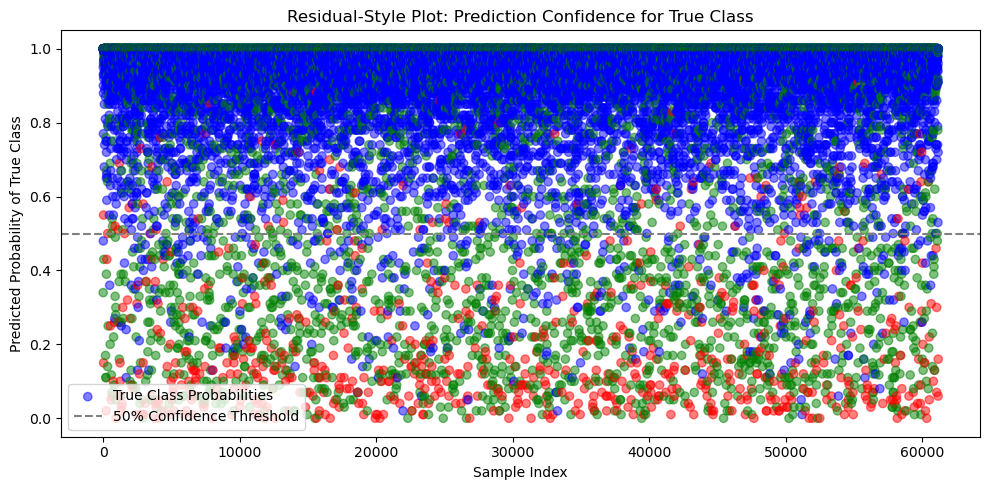

In [135]:
# Get predicted probabilities
y_proba = clf.predict_proba(X_test)

# Map class labels to indices
label_to_index = {label: i for i, label in enumerate(clf.classes_)}
true_indices = y_test.map(label_to_index)

# Extract the probability assigned to the true class for each prediction
true_class_probs = [probs[i] for probs, i in zip(y_proba, true_indices)]

# Plot: True class probability vs. true label
plt.figure(figsize=(10, 5))
plt.scatter(range(len(true_class_probs)), true_class_probs, c=y_test.map({'Gain': 'blue', 'Loss': 'red', 'Stable': 'green'}), alpha=0.5, label='True Class Probabilities')
plt.axhline(0.5, color='gray', linestyle='--', label='50% Confidence Threshold')
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability of True Class")
plt.title("Residual-Style Plot: Prediction Confidence for True Class")
plt.legend()
plt.tight_layout()
plt.show()

#### Confusion Matrix — CHM + Terrain + Vegetation Model

We visualized a confusion matrix to evaluate model performance across the canopy change classes. 

Key takeaways:

- **Gain** and **Stable** classes are classified with high accuracy and minimal confusion.
- **Loss** remains difficult to detect, with many misclassified as Gain or Stable. This is likely due to its small sample size and overlapping feature characteristics.
- The matrix highlights the value of rebalancing strategies or alternative modeling approaches (e.g., class-specific models) if loss detection is critical.

This step validated overall model strength while clarifying which classes need further diagnostic attention.

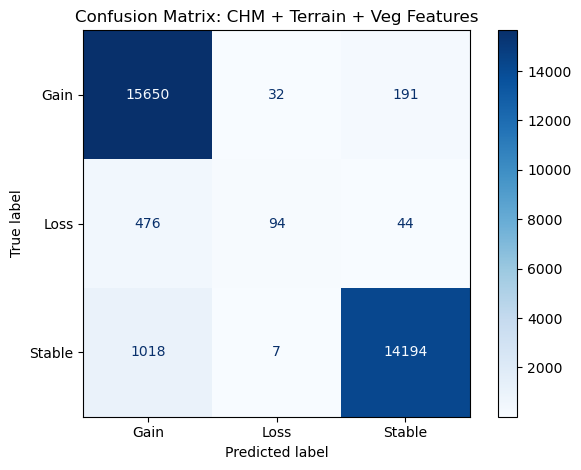

In [146]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load data and label
df = pd.read_csv("D:/MSDS/MSDS 696_Practicum II/block_features_final.csv")
df['label'] = df.apply(lambda row: (
    'Gain' if row['chm_pct_gain'] > 10 else
    'Loss' if row['chm_pct_loss'] > 10 else
    'Stable'
), axis=1)

# Prepare features and labels
features = [
    'chm_mean', 'chm_std', 'chm_min', 'chm_max', 'chm_p95', 'chm_median', 'chm_iqr',
    'NDVI_mean', 'EVI_mean', 'ARVI_mean', 'PRI_mean', 'SAVI_mean',
    'slope_mean', 'aspect_mean'
]
df_model = df.dropna(subset=features + ['label'])
X = df_model[features]
y = df_model['label']

# Train/test split and model fit
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Gain', 'Loss', 'Stable'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gain', 'Loss', 'Stable'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: CHM + Terrain + Veg Features")
plt.tight_layout()
plt.show()

## Phase 7: Spatial Prediction and Visualization

### Step 1: Exporting Predicted Canopy Change Labels

To support spatial mapping and analysis, we exported the model's predicted class labels (Gain, Loss, Stable) along with block-level metadata: site, year, row and column offsets.

The resulting file, `predicted_blocks.csv`, enables direct integration into GIS platforms or spatial visualization tools for examining the geographic distribution of predicted canopy change.

This sets up the next step—mapping or aggregating predictions at the site or landscape level.

In [144]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data and re-label
df = pd.read_csv("D:/MSDS/MSDS 696_Practicum II/block_features_final.csv")
df['label'] = df.apply(lambda row: (
    'Gain' if row['chm_pct_gain'] > 10 else
    'Loss' if row['chm_pct_loss'] > 10 else
    'Stable'
), axis=1)

# Drop NA, define features
features = [
    'chm_mean', 'chm_std', 'chm_min', 'chm_max', 'chm_p95', 'chm_median', 'chm_iqr',
    'NDVI_mean', 'EVI_mean', 'ARVI_mean', 'PRI_mean', 'SAVI_mean',
    'slope_mean', 'aspect_mean'
]
df_model = df.dropna(subset=features + ['label']).copy()
X = df_model[features]
y = df_model['label']

# Split, train model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict on entire dataset for export
df_model['predicted'] = clf.predict(X)

# Export CSV with coords + predictions
export_cols = ['site', 'year', 'row_off', 'col_off', 'label', 'predicted']
df_model[export_cols].to_csv("D:/MSDS/MSDS 696_Practicum II/predicted_blocks.csv", index=False)
print("✅ Exported block predictions with coordinates.")

✅ Exported block predictions with coordinates.


### Step 2: Visualizing Predicted Canopy Change Blocks

To better understand spatial patterns of model predictions, we created scatter plots of predicted canopy change classes (`Gain`, `Loss`, `Stable`) for individual site-year mosaics. Each 100×100 pixel block is plotted using its offset coordinates, and colored according to its predicted class. This helps visualize spatial structure and clustering of changes across the landscape.

In this example, we focused on NIWO in 2018. Adjusting the `site_filter` allows us to explore different site-year predictions.


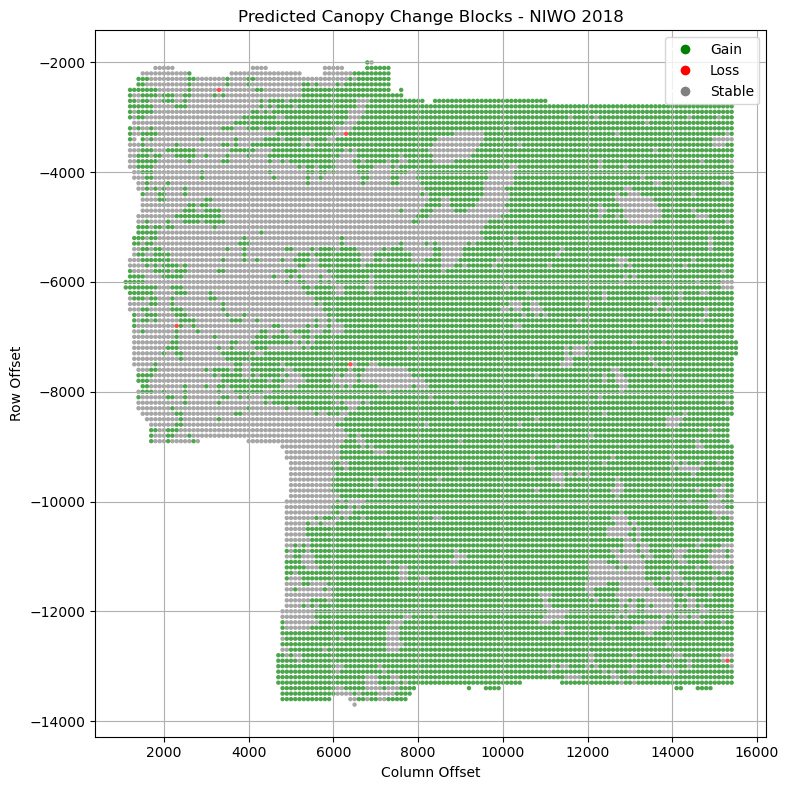

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions
df = pd.read_csv("D:/MSDS/MSDS 696_Practicum II/predicted_blocks.csv")

# Focus on a single site-year
site_filter = (df['site'] == 'NIWO') & (df['year'] == 2018)
df_plot = df[site_filter].copy()

# Create color mapping
label_colors = {'Gain': 'green', 'Loss': 'red', 'Stable': 'gray'}
df_plot['color'] = df_plot['predicted'].map(label_colors)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(df_plot['col_off'], -df_plot['row_off'], 
            c=df_plot['color'], s=10, alpha=0.7, edgecolors='none')

plt.title("Predicted Canopy Change Blocks - NIWO 2018")
plt.xlabel("Column Offset")
plt.ylabel("Row Offset")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Gain', markerfacecolor='green', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Loss', markerfacecolor='red', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='gray', markersize=8)
])
plt.tight_layout()
plt.show()

Display limits: lower=-2.49, upper=5.39


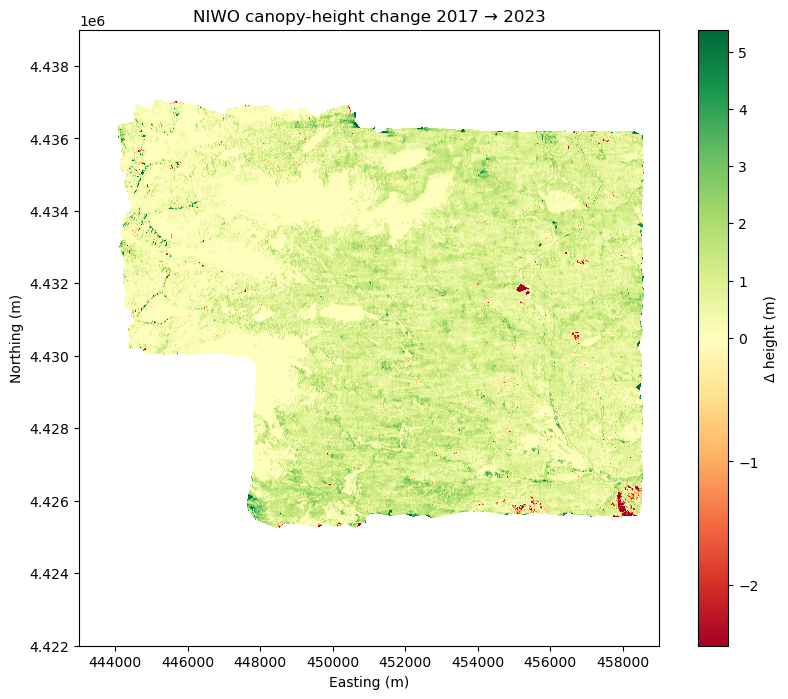

In [161]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent

# Path to the difference raster
diff_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\aligned_mosaics\NIWO\differences\NIWO_CHM_2023_diff.tif"

# Read the raster and its plotting extent
with rasterio.open(diff_path) as src:
    diff_data = src.read(1).astype("float32")
    extent = plotting_extent(src)
    nodata = src.nodata if src.nodata is not None else -9999

# Replace nodata (-9999) with NaN so it is ignored
diff_data_vis = np.where(diff_data == nodata, np.nan, diff_data)

# Compute 2- and 98-percentile values for robust colour stretch
valid_vals = diff_data_vis[np.isfinite(diff_data_vis)]
lower, upper = np.percentile(valid_vals, [2, 98])
print(f"Display limits: lower={lower:.2f}, upper={upper:.2f}")

# Normalise colours so 0 m change is white, losses red, gains green
norm = colors.TwoSlopeNorm(vmin=lower, vcenter=0, vmax=upper)

# Plot the difference raster
plt.figure(figsize=(10, 8))
plt.imshow(diff_data_vis, extent=extent, cmap="RdYlGn", origin="upper", norm=norm)
plt.title("NIWO canopy-height change 2017 → 2023")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
cbar = plt.colorbar()
cbar.set_label("Δ height (m)")
plt.show()

### Visual Comparison of Predicted vs. Actual Canopy Height Change (NIWO)

To assess the spatial accuracy of our Random Forest predictions, we compared model-derived block classifications with the raw CHM difference raster for the NIWO site.

- **Left Plot**: Shows predicted canopy change blocks for NIWO 2018, classified as **Gain** (green), **Loss** (red), or **Stable** (gray). These predictions are based on structural, vegetation, and terrain features, plotted using `col_off` and `row_off` offsets within the raster grid.
  
- **Right Plot**: Displays the actual canopy height difference from 2017 to 2023 using CHM data. A diverging colormap (`RdYlGn`) is used to highlight **gain** in green, **loss** in red, and **minimal change** in yellow.

**Interpretation**:
- There is strong spatial agreement between the predicted gain regions and the green-highlighted areas in the CHM difference raster.
- Loss events remain sparse but show some overlap across both representations, supporting the challenge of modeling rare disturbance events.
- This comparison provides qualitative validation that the model is learning from meaningful spatial patterns in the input data.

## Final Project Summary

This project leveraged NEON Canopy Height Model (CHM), terrain, and vegetation index data to detect and classify canopy change at the block level across multiple ecological sites. After aligning and validating spatial inputs, we extracted structural features (e.g., CHM mean, p95, IQR), terrain attributes (slope, aspect), and vegetation indices (NDVI, EVI, etc.) over 100×100 pixel windows.

Blocks were labeled as **Gain**, **Loss**, or **Stable** based on 10% thresholds of canopy change, informed by a sensitivity analysis to ensure meaningful class distribution.

We trained Random Forest models on:
- **Terrain-only features** to assess baseline predictive power  
- **All features combined** to evaluate full ecological signal integration

Model performance was strong (96% overall accuracy), with highest precision and recall for Stable and Gain classes. While Loss remained the most difficult to detect, confusion matrix and residual-style plots highlighted spatial and confidence-based error patterns.

Finally, we visualized predicted canopy change maps alongside raw CHM difference rasters, revealing strong spatial correspondence and offering actionable ecological insight.

---

### Next Steps & Opportunities for Improvement

- **Improve Loss Detection:** Try other models (like XGBoost) or oversample the rare Loss class to improve prediction accuracy.
- **Add More Features:** Include elevation, weather or other terrain-based variables if available.
- **Map Validation:** Compare predictions to field data or published disturbance maps to verify accuracy.
- **Use in Practice:** Consider how this method could help managers monitor forest change more efficiently.

These steps would help strengthen the model and expand its usefulness for ecological monitoring.